# FIT5202 Data processing for Big data

##  Activity: Assignment 1


##### Student ID: `31265154`
##### Student Name: `Vivekkumar Chaudhari`


### Table of Contents

* [1 Working with RDD](#one)
    * [1.1 Data Loading with RDD](#oneone)
        * [1.1.1 SparkContext object from SparkSession creation](#oneoneone)
        * [1.1.2 Read data from file](#oneonetwo)
        * [1.1.3 Printing RDD information](#oneonethree)
    * [1.2 Analysis](#onetwo)
        * [1.2.1 Range partitioning in RDD](#onetwoone)
        * [1.2.2 Get trend from 2009 to 2020 [RDD]](#onetwotwo)
        * [1.2.3 Top-5 Sensor data display [RDD]](#onetwothree)
* [2 Working with DataFrames](#two)
    * [2.1 Data Loding with DataFrames](#twoone)
        * [2.1.1 & 2.1.2 ](#twooneonetwo)
        * [2.1.3 (a)](#twoonethreea)
        * [2.1.3 (b, c, d)](#twoonethreebcd)
    * [2.2 Analysis - Using DataFrames](#twotwo)
        * [2.2.1 Get trend from 2009 to 2020 [DataFrames]](#twotwoone)
        * [2.2.2 Top-5 Sensor data display [DataFrames]](#twotwotwo)
        * [2.2.3 Pedestrian counts breakdown](#twotwothree)
        * [2.2.4 Pedestrian Count Timings](#twotwofour)
* [3 Performance Analysis](#three)
    * [3.1 Performance comparision](#threeone)
        * [3.1.1 Screenshots of Spark UI for question 1.2.3 and 2.2.2](#threeoneone)
        * [3.1.2 Comparision explanation](#threeonetwo)
    * [3.2 Performance Improvement](#threetwo)
        * [3.2.1 Screenshots of Spark UI - SQL tab for Question 2.2.4](#threetwoone)
        * [3.2.2 SQL Query explanation](#threetwotwo)
        

<a class="anchor" name="one"></a>
## Working with RDD
<a class="anchor" name="oneone"></a>
### 1.1 Data Loading with RDD
<a class="anchor" name="oneoneone"></a>
#### 1.1.1 SparkContext object from SparkSession creation

In [1]:
## Import SparkContext and SparkSession classes
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

## Creating Spark Configuration
# Use all available cores
master = "local[*]"
# Spark Application name
app_name = "FIT5202 - Assignment 1"
# Seeting timezone to Australia/Victoria
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.session.timeZone", "Australia/Victoria")

## Createing SparkSession and SparkContext from it.
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
# Setting loglevel to 'ERROR'
sc.setLogLevel("ERROR")

<a class="anchor" name="oneonetwo"></a>
#### 1.1.2 Read data from file

In [2]:
# import datetime parser libs to convert and store datetime object
from datetime import datetime
# import sql's Row datatype to map rdd items. 
from pyspark.sql import Row

# Read Monthly Pedestrian count csv file to RDD
rdd_ped_count_1 = sc.textFile('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv')
# Read Sensor location csv file to RDD
rdd_sen_loc_1 = sc.textFile('Pedestrian_Counting_System_-_Sensor_Locations.csv')

# exclude the first header row from monthly ped. count rdd.
rdd_ped_count_2 = rdd_ped_count_1.filter(lambda row: row.split(",")[0].strip().lower() != "id")
# exclude the first header row from sensor location rdd.
rdd_sen_loc_2 = rdd_sen_loc_1.filter(lambda row: row.split(",")[0].strip().lower() != "sensor_id")

# format each record of monthly ped. count rdd to ROW object.
# And convert datetime and numeric fields. 
rdd_ped_count_3 = rdd_ped_count_2\
    .map(lambda line: line.split(','))\
    .filter(lambda line: line != "")\
    .map(lambda line : Row(ID=int(line[0].strip()) if line[0].strip().isdigit() else line[0].strip(), 
                         Date_Time=datetime.strptime(line[1], '%m/%d/%Y %I:%M:%S %p'),
                         Year=int(line[2].strip()) if line[2].strip().isdigit() else line[2].strip(), 
                         Month=line[3], 
                         Mdate=int(line[4].strip()) if line[4].strip().isdigit() else line[4].strip(), 
                         Day=line[5], 
                         Time=int(line[6].strip()) if line[6].strip().isdigit() else line[6].strip(), 
                         Sensor_ID=int(line[7].strip()) if line[7].strip().isdigit() else line[7].strip(), 
                         Sensor_Name=line[8], 
                         Hourly_Counts=int(line[9].strip()) if line[9].strip().isdigit() else line[9].strip()))

# format each record of sensor location rdd to ROW object.
# And convert datetime and numeric fields. 
rdd_sen_loc_3 = rdd_sen_loc_2\
    .map(lambda line: line.split(','))\
    .filter(lambda line: line != "")\
    .map(lambda line : Row(sensor_id=int(line[0]), 
                         sensor_description=line[1], 
                         sensor_name=line[2], 
                         installation_date=datetime.strptime(line[3], '%Y/%m/%d'), 
                         status=line[4], 
                         note=line[5], 
                         direction_1=line[6], 
                         direction_2=line[7], 
                         latitude=float(line[8]), 
                         longitude=float(line[9]), 
                         location=(float(line[10].lstrip("\"(")), float(line[11].rstrip(")\"")))))

<a class="anchor" name="oneonethree"></a>
#### 1.1.3 Printing RDD information

In [3]:
# We use default partitioning of RDD. as it is fast compare to others.(that involves Coalesce and data Shuffling).

# Print the Monthly PED. Count RDD information
print(f"\n::Pedestrian Monthly Count RDD::\n")
print(f"Number of Columns: {len(rdd_ped_count_3.first())}")
# Here, we use rdd which is not formatted to ROW object to get faster result of number of records. 
print(f"Total number of Records: {rdd_ped_count_2.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()}")
print("First two Records:")
for index, row in enumerate(rdd_ped_count_3.take(2)):
        print(f"Row {index + 1}: {row} \n")

# Print the SEnsor location RDD information
print(f"\n::Sensor Locations RDD::\n")
print(f"Number of Columns: {len(rdd_sen_loc_3.first())}")
# Here, we use rdd which is not formatted to ROW object to get faster result of number of records. 
print(f"Total number of Records: {rdd_sen_loc_2.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()}")
print("First two Records:")
for index, row in enumerate(rdd_sen_loc_3.take(2)):
        print(f"Row {index + 1}: {row} \n")


::Pedestrian Monthly Count RDD::

Number of Columns: 10
Total number of Records: 3435106
First two Records:
Row 1: Row(ID=2887628, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=34, Sensor_Name='Flinders St-Spark La', Hourly_Counts=300) 

Row 2: Row(ID=2887629, Date_Time=datetime.datetime(2019, 11, 1, 17, 0), Year=2019, Month='November', Mdate=1, Day='Friday', Time=17, Sensor_ID=39, Sensor_Name='Alfred Place', Hourly_Counts=604) 


::Sensor Locations RDD::

Number of Columns: 11
Total number of Records: 72
First two Records:
Row 1: Row(sensor_id=59, sensor_description='Building 80 RMIT', sensor_name='RMIT_T', installation_date=datetime.datetime(2019, 2, 13, 0, 0), status='A', note='', direction_1='North', direction_2='South', latitude=-37.80825648, longitude=144.96304859, location=(-37.80825648, 144.96304859)) 

Row 2: Row(sensor_id=20, sensor_description='Chinatown-Lt Bourke St (South)', sensor_name='LtB170_T', 

<a class="anchor" name="onetwo"></a>
### 1.2 Analysis
<a class="anchor" name="onetwoone"></a>
#### 1.2.1 Range partitioning in RDD

In [4]:
# function to print partition information of given RDD.
def print_partiotion_info(rddObj):
    print(f"Number of Partition: {rddObj.getNumPartitions()}")
    print(f"Number of Records in each Partition: ")
    # map RDD's all partitions to individual sum of records in each partition.
    for index, rec in enumerate(rddObj.mapPartitions(lambda itr: [sum(1 for _ in itr)]).collect()):
        print(f"Partition {index + 1}: {rec} record(s)")

# get maximum Hourly_Counts value from monthly ped. count RDD.
max_hour_count = rdd_ped_count_2.\
    max(key=lambda row: int(row.split(",")[9].strip()) if row.split(",")[9].strip().isdigit() else 0)

# define list of ranges based on maximum Hourly_Counts value
range_part_array = [[i, i + 999] for i in range(0, int(max_hour_count.split(",")[9]), 1000)]

# function to check given key values is in which range of array inside list of ranges and 
# returns the index of that array.
def range_function(key):
    for index, item in enumerate(range_part_array):
        if key >= item[0] and key <= item[1]:
            return index

# map the monthly ped. count RDD to key-value pair: key as Hourly_Counts and values as entire row
# partition this rdd by range_function.
range_partitioned_rdd = rdd_ped_count_3.\
    map(lambda x: [x.Hourly_Counts, x]).\
    partitionBy(len(range_part_array), range_function)

# print the newly created partition information.
print_partiotion_info(range_partitioned_rdd)

Number of Partition: 16
Number of Records in each Partition: 
Partition 1: 2795353 record(s)
Partition 2: 388811 record(s)
Partition 3: 168802 record(s)
Partition 4: 61993 record(s)
Partition 5: 15829 record(s)
Partition 6: 3779 record(s)
Partition 7: 337 record(s)
Partition 8: 110 record(s)
Partition 9: 44 record(s)
Partition 10: 29 record(s)
Partition 11: 8 record(s)
Partition 12: 8 record(s)
Partition 13: 1 record(s)
Partition 14: 0 record(s)
Partition 15: 1 record(s)
Partition 16: 1 record(s)


<a class="anchor" name="onetwotwo"></a>
#### 1.2.2 Get trend from 2009 to 2020 [RDD]

In [5]:
# import rdd operator to perform addition. 
from operator import add

## table 1: contains year wise sum of Hourly_Counts records.
# Steps:
# 1 -> filter year between 2009 and 2020.
# 2 -> map result that contain only year and Hourly_Counts
# 3 -> use 'foldByKey' on rdd and perform add operation to count sum of Hourly_Counts as Yearly_Total_Count.
rdd_tbl1 = rdd_ped_count_3\
    .filter(lambda row: row.Year >= 2009 and row.Year <= 2020)\
    .map(lambda row: [row.Year, row.Hourly_Counts])\
    .foldByKey(0, add)

# creating initial default tuple. 
aTuple = (0, 0)
## table 2: contains year wise sum of Hourly_Counts records.
# Steps:
# 1 -> filter year between 2009 and 2020.
# 2 -> map result that contain one string of year#month#mdate and Hourly_Counts
# 3 -> use 'foldByKey' on rdd and perform add operation to count sum of Hourly_Counts as Daily_Count.
# 4 -> map results that contain year and Daily_Count.
# 5 -> find average of Daily_Count by 'aggregateByKey' and 'mapValues'.
#      5.1 -> create two operations in aggregateByKey. use starting tuple as default tuple.
#             operation 1: calculate sum of Daily_Count by key group(year).
#             operation 2: calculate the count of records by key group(year).
rdd_tbl2 = rdd_ped_count_3\
    .filter(lambda row: row.Year >= 2009 and row.Year <= 2020)\
    .map(lambda row: [f"{row.Year}#{row.Month}#{row.Mdate}", row.Hourly_Counts])\
    .foldByKey(0, add)\
    .map(lambda row: (int(row[0].split("#")[0]), row[1]))\
    .aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda val: round(val[0] / val[1], 2))

## final table: contains the result.
# Steps:
# 2 -> join table 1 and table 2.
# 3 -> sort result by key(=year).
rdd_tbl3 = rdd_tbl1\
    .join(rdd_tbl2)\
    .sortByKey(True, 1)

# Printing the result
print("The trend from 2009 to 2020 in terms of the yearly total pedestrian counts and the average daily pedestrian counts:")
print('-' * 50)
for index, val in enumerate(rdd_tbl3.collect()):
    if index == 0:
        print('|{:>5s}|{:>20s}|{:>20s}|'.format("Year", "Yearly_Total_Count", "Average_Daily_Count"))
        print('-' * 50)
    print('|{:5d}|{:20d}|{:20.2f}|'.format(val[0], val[1][0], val[1][1]))
print('-' * 50)

# REFERENCES:
# [1] https://stackoverflow.com/questions/51690965/spark-aggregatebykey-sum-and-running-average-in-the-same-call
# [2] https://hyukjin-spark.readthedocs.io/en/stable/reference/pyspark.html#rdd-apis

The trend from 2009 to 2020 in terms of the yearly total pedestrian counts and the average daily pedestrian counts:
--------------------------------------------------
| Year|  Yearly_Total_Count| Average_Daily_Count|
--------------------------------------------------
| 2009|            62650110|           255714.73|
| 2010|            93459437|           256053.25|
| 2011|            90571965|           248142.37|
| 2012|           102215521|           279277.38|
| 2013|           117389820|           321615.95|
| 2014|           169500386|           464384.62|
| 2015|           209099687|           572875.85|
| 2016|           228757880|           625021.53|
| 2017|           216586414|           593387.44|
| 2018|           261909318|           717559.78|
| 2019|           266411675|           729895.00|
| 2020|           107788571|           321756.93|
--------------------------------------------------


<a class="anchor" name="onetwothree"></a>
#### 1.2.3 Top-5 Sensor data display [RDD]

In [6]:
# creating initial default tuple. 
aTuple = (0, 0)
## table 1: contains top 5 sensor id wise average Hourly_Counts records.
# Steps:
# 1 -> map monthly ped. count rdd to sensor id and Hourly_Counts records.
# 2 -> find average of Hourly_Counts by 'aggregateByKey' and 'mapValues'.
#      2.1 -> create two operations in aggregateByKey. use starting tuple as default tuple.
#             operation 1: calculate sum of Hourly_Counts by key group(sensor id).
#             operation 2: calculate the count of records by key group(sensor id).
# 3 -> map resulting value of 'aggregateByKey' to find average.
# 4 -> sort result by Hourly_Counts in descending order.
# 5 -> zip the result with indexes. that contains a row with (sensor id, Average_Hourly_Count) and index.
# 6 -> filter top 5 records.
# 7 -> map the result that exclude index and contain only sensor id and Average_Hourly_Count. 
rdd_tbl4 = rdd_ped_count_3\
    .map(lambda row: [row.Sensor_ID, row.Hourly_Counts])\
    .aggregateByKey(aTuple, lambda a,b: (a[0] + b, a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1]))\
    .mapValues(lambda val: round(val[0] / val[1], 2))\
    .sortBy(lambda row: -row[1])\
    .zipWithIndex()\
    .filter(lambda keyIndexRow: keyIndexRow[1] < 5)\
    .map(lambda row: row[0])

## final table: contains the result.
# Steps:
# 1 -> map rows from sensor location dataframes.
# 2 -> join table 1 and this dataframe.
# 3 -> sort result by Average_Hourly_Count in descending order.
rdd_tbl5 = rdd_sen_loc_3\
    .map(lambda row: [row.sensor_id, row.sensor_description])\
    .join(rdd_tbl4)\
    .sortBy(lambda row: -row[1][1])

# Printing the result
print("Showing top-5 sensors with the highest average hourly pedestrian counts:")
print('-' * 85)
for index, val in enumerate(rdd_tbl5.take(5)):
    if index == 0:
        print('|{:>10s}| {:<50s}|{:>20s}|'.format("Sensor ID", "Sensor Description", "Average_Hourly_Count"))
        print('-' * 85)
    print('|{:10d}| {:<50s}|{:20.2f}|'.format(val[0], val[1][0], val[1][1]))
print('-' * 85)

# REFERENCES:
# [1] https://stackoverflow.com/questions/51690965/spark-aggregatebykey-sum-and-running-average-in-the-same-call
# [2] https://hyukjin-spark.readthedocs.io/en/stable/reference/pyspark.html#rdd-apis

Showing top-5 sensors with the highest average hourly pedestrian counts:
-------------------------------------------------------------------------------------
| Sensor ID| Sensor Description                                |Average_Hourly_Count|
-------------------------------------------------------------------------------------
|        38| Flinders St-Swanston St (West)                    |             2448.78|
|        60| Flinders La - Swanston St (West) Temporary        |             1600.07|
|        41| Flinders La-Swanston St (West)                    |             1454.79|
|        22| Flinders St-Elizabeth St (East)                   |             1433.37|
|         4| Town Hall (West)                                  |             1419.59|
-------------------------------------------------------------------------------------


<a class="anchor" name="two"></a>
## Working with DataFrames
#### SparkContext object from SparkSession creation

<a class="anchor" name="twoone"></a>
### 2.1 Data Loding with DataFrames
<a class="anchor" name="twooneonetwo"></a>
#### 2.1.1 & 2.1.2

In [7]:
# importing sql functions
from pyspark.sql.functions import *
# import sql types
import pyspark.sql.types as st

# defining the schema of monthly ped. count dataframe
monthly_pad_count_schema = st.StructType([
    st.StructField('ID', st.IntegerType(), True),
    st.StructField('Date_Time', st.StringType(), True),
    st.StructField('Year', st.IntegerType(), True),
    st.StructField('Month', st.StringType(), True),
    st.StructField('Mdate', st.IntegerType(), True),
    st.StructField('Day', st.StringType(), True),
    st.StructField('Time', st.IntegerType(), True),
    st.StructField('Sensor_ID', st.IntegerType(), True),
    st.StructField('Sensor_Name', st.StringType(), True),
    st.StructField('Hourly_Counts', st.IntegerType(), True),
])

# defining the schema of sensor location dataframe
sensor_location_schema = st.StructType([
    st.StructField('sensor_id', st.IntegerType(), True),
    st.StructField('sensor_description', st.StringType(), True),
    st.StructField('sensor_name', st.StringType(), True),
    st.StructField('installation_date', st.StringType(), True),
    st.StructField('status', st.StringType(), True),
    st.StructField('note', st.StringType(), True),
    st.StructField('direction_1', st.StringType(), True),
    st.StructField('direction_2', st.StringType(), True),
    st.StructField('latitude', st.FloatType(), True),
    st.StructField('longitude', st.FloatType(), True),
    st.StructField('location', st.StringType(), True),
])

# reading monthly ped. counts csv file to dataframe with header and schema.
df_csv_pad_count = spark.read\
    .format('csv')\
    .option("header", "true")\
    .schema(monthly_pad_count_schema)\
    .load('Pedestrian_Counting_System_-_Monthly__counts_per_hour.csv')

# reading sensor locations csv file to dataframe with header and schema.
df_csv_sen_loc = spark.read\
    .format('csv')\
    .option("header", "true")\
    .schema(sensor_location_schema)\
    .load('Pedestrian_Counting_System_-_Sensor_Locations.csv')

# print the schema of monthly ped. count csv dataframe
df_csv_pad_count.printSchema()
# print the schema of sensor location csv dataframe
df_csv_sen_loc.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: string (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: string (nullable = true)



<a class="anchor" name="twoonethreea"></a>
#### 2.1.3 (a)

In [8]:
# importing sql functions
from pyspark.sql.functions import *

# printing records that has id 2853222 and 2853223 of monthly ped. count dataframe.
print("Before Date-Time transformation:")
df_csv_pad_count.filter(df_csv_pad_count.ID.isin(2853222, 2853223)).select("ID", "Date_Time").show(truncate = False)

# change column 'Date_Time' values from string to datetime object.
df_monthly_pad_count = df_csv_pad_count.withColumn("Date_Time", to_timestamp("Date_Time", "MM/dd/yyyy hh:mm:ss a"))

# printing records that has id 2853222 and 2853223 of monthly ped. count dataframe.
print("After Date-Time transformation:")
df_monthly_pad_count.filter(df_monthly_pad_count.ID.isin(2853222, 2853223)).select("ID", "Date_Time").show(truncate = False)


Before Date-Time transformation:
+-------+----------------------+
|ID     |Date_Time             |
+-------+----------------------+
|2853222|10/06/2019 02:00:00 AM|
|2853223|10/06/2019 03:00:00 AM|
+-------+----------------------+

After Date-Time transformation:
+-------+-------------------+
|ID     |Date_Time          |
+-------+-------------------+
|2853222|2019-10-06 03:00:00|
|2853223|2019-10-06 03:00:00|
+-------+-------------------+



<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE">Issues</strong> <br>
    <ul>
        <li>
            See, timing difference for <code>ID=2853222</code>
            <br>
            &nbsp;&nbsp;&nbsp;&nbsp;It is due to <code>to_timestamp</code> method convert given <code>time string</code> to <code>current timezone (Australia\Melbourne)</code>.
        </li>
        <li>
            Loading times: To change datatype of column after dataframe loaded, requires parse every records again, so it becomes quite expensive for very large datasets.
        </li>
    </ul>
    <strong style="color:#006DAE">Approaches</strong> <br>
    <ul>
        <li>
            For Date time string <code>column</code>, we need to convert it to <code>datetime object</code> with specifying <code>timezone</code> or <code>default(=current timezone)</code>. 
            <br>
            &nbsp;&nbsp;&nbsp;&nbsp; There are other fields, we can convert like: currency, numerical values, etc. 
        </li>
        <li>
            Define well balanced schema in advance or use auto-schema option while loading data to dataframes. This will reduce unnecessory post datatype change load.
        </li>
    </ul>
</div>

<a class="anchor" name="twoonethreebcd"></a>
#### 2.1.3 (b, c, d)

In [9]:
# importing sql types
from pyspark.sql.types import ArrayType, FloatType
# importing sql functions
from pyspark.sql.functions import *

# udf function to convert 'location' column values to array of two float values
to_float_array = udf(lambda x: [float(x.split(',')[0].lstrip("(")), float(x.split(',')[1].rstrip(")"))], ArrayType(FloatType()))

# change column 'installation_date' value to datetime object.
# cahnge column 'location' value to array of floats.
df_sensor_location = df_csv_sen_loc\
    .withColumn("installation_date", to_timestamp("installation_date", "yyyy/MM/dd"))\
    .withColumn("location", to_float_array("location"))

# print the schema of monthly ped. count dataframe
df_monthly_pad_count.printSchema()
# print the schema of sensor location dataframe
df_sensor_location.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: timestamp (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- location: array (nullable = true)
 |    |-- element: float (containsNull = true)



<a class="anchor" name="twotwo"></a>
### 2.2 Analysis - Using DataFrames
<a class="anchor" name="twotwoone"></a>
#### 2.2.1 Get trend from 2009 to 2020 [DataFrames]

In [10]:
# importing sql functions
from pyspark.sql.functions import *

## table 1: contains year wise sum of Hourly_Counts values.
# Steps
# 1 -> filter year between 2009 to 2020.
# 2 -> group by year and do sum of Hourly_Counts values.
# 3 -> sort result by year.
# 4 -> select required columns.
df_tbl1 = df_monthly_pad_count\
    .where(df_monthly_pad_count.Year.between(2009, 2020))\
    .groupBy("Year")\
    .agg(sum("Hourly_Counts").alias("Yearly_Total_Count"))\
    .orderBy("Year")\
    .select(col("Year").alias("y1"), "Yearly_Total_Count")

## table 2: contains year, month, and date wise sum of Hourly_Counts values.
# Steps
# 1 -> filter year between 2009 to 2020.
# 2 -> group by year, month, and date and do sum of Hourly_Counts values.
# 3 -> sort result by year.
# 4 -> select required columns.
df_tbl2 = df_monthly_pad_count\
    .where(df_monthly_pad_count.Year.between(2009, 2020))\
    .groupBy("Year", "Month", "Mdate")\
    .agg(sum("Hourly_Counts").alias("Daily_Count"))\
    .orderBy("Year")\
    .select(col("Year").alias("y2"), "Daily_Count")


## final table: contains the result
# Steps
# 1 -> inner join table 1 and table 2.
# 2 -> group by year and table 1's yearly count and get average of Daily count values of table 2.
# 3 -> sort result by year.
# 4 -> select required columns and show result.
print("The trend from 2009 to 2020 in terms of the yearly total pedestrian counts and the average daily pedestrian counts:")
df_tbl2\
    .join(broadcast(df_tbl1), df_tbl1.y1==df_tbl2.y2, how='inner')\
    .groupBy(df_tbl1.y1, df_tbl1.Yearly_Total_Count)\
    .agg(round(avg("Daily_Count"), 2).alias("Average_Daily_Count"))\
    .orderBy(df_tbl1.y1)\
    .select(df_tbl1.y1.alias("Year"), df_tbl1.Yearly_Total_Count, "Average_Daily_Count")\
    .show()

The trend from 2009 to 2020 in terms of the yearly total pedestrian counts and the average daily pedestrian counts:
+----+------------------+-------------------+
|Year|Yearly_Total_Count|Average_Daily_Count|
+----+------------------+-------------------+
|2009|          62650110|          255714.73|
|2010|          93459437|          256053.25|
|2011|          90571965|          248142.37|
|2012|         102215521|          279277.38|
|2013|         117389820|          321615.95|
|2014|         169500386|          464384.62|
|2015|         209099687|          572875.85|
|2016|         228757880|          625021.53|
|2017|         216586414|          593387.44|
|2018|         261909318|          717559.78|
|2019|         266411675|           729895.0|
|2020|         107788571|          321756.93|
+----+------------------+-------------------+



<a class="anchor" name="twotwotwo"></a>
#### 2.2.2 Top-5 Sensor data display [DataFrames]

In [11]:
# importing sql functions
from pyspark.sql.functions import *

## Main query:
# Steps:
# 1 -> group by monthly ped. count df's by sensor id and get average of Hourly_Counts values by aggregate.
# 2 -> sort result by Average_Hourly_Count.
# 3 -> limit the result rows to top 5 rows.
# 4 -> inner join sensor dataframe.
# 5 -> sort results by Average_Hourly_Count.
# 6 -> select requied columns and show the result.
print("Showing top-5 sensors with the highest average hourly pedestrian counts:")
df_monthly_pad_count\
    .groupBy(df_monthly_pad_count.Sensor_ID)\
    .agg(round(avg("Hourly_Counts"), 2).alias("Average_Hourly_Count"))\
    .orderBy(col("Average_Hourly_Count").desc())\
    .limit(5)\
    .join(df_sensor_location, df_monthly_pad_count.Sensor_ID==df_sensor_location.sensor_id, "inner")\
    .orderBy(col("Average_Hourly_Count").desc())\
    .select(df_monthly_pad_count.Sensor_ID.alias("Sensor ID"), \
            df_sensor_location.sensor_description.alias("Sensor Description"), \
            "Average_Hourly_Count")\
    .show(truncate = False)

Showing top-5 sensors with the highest average hourly pedestrian counts:
+---------+------------------------------------------+--------------------+
|Sensor ID|Sensor Description                        |Average_Hourly_Count|
+---------+------------------------------------------+--------------------+
|38       |Flinders St-Swanston St (West)            |2448.78             |
|60       |Flinders La - Swanston St (West) Temporary|1600.07             |
|41       |Flinders La-Swanston St (West)            |1454.79             |
|22       |Flinders St-Elizabeth St (East)           |1433.37             |
|4        |Town Hall (West)                          |1419.59             |
+---------+------------------------------------------+--------------------+



<a class="anchor" name="twotwothree"></a>
#### 2.2.3 Pedestrian counts breakdown

In [12]:
# importing sql types
from pyspark.sql.types import IntegerType
# importing sql functions
from pyspark.sql.functions import *

# udf function to get week day as number from week day name as string
get_week_day = udf(lambda cellVal: {"mon": 1, "tue": 2, "wed": 3, "thu": 4, "fri": 5, "sat": 6, "sun": 7}[cellVal[:3].lower()], IntegerType())
# udf function to get cell value as 'Subtotal' if it is null else as it is.
colVal_replace = udf(lambda cellVal: cellVal if cellVal else "Subtotal")


print("Breakdown structure of daily pedestrian counts:")
## Main query:
# Steps:
# 1 -> filter monthly ped. count df's Date_Time column values between 2019-07-01 00:00:00 to 2019-07-28 00:00:00
# 2 -> add new column 'week' that contains week number of the year
# 3 -> add new column 'dayofweek' that contains week number as 1 to 7 relates to MON to SUN.
# 4 -> roll up the results based on columns week and dayofweek and find sum of Hourly_Counts column values using aggregate. 
#      (this will do basic groupby and get sum of pair values of given grouping columns)
# 5 -> sort results by 'Week' and 'DayofWeek' columns.
# 6 -> select required columns.
# 7 -> change column 'DayofWeek' value to replace null values.
# 8 -> filter top row.
# 9 -> show the results.
df_monthly_pad_count\
    .filter(df_monthly_pad_count.Date_Time >= (lit("2019-07-01 00:00:00")))\
    .filter(df_monthly_pad_count.Date_Time <= (lit("2019-07-28 00:00:00")))\
    .withColumn("Week", weekofyear(df_monthly_pad_count.Date_Time))\
    .withColumn("DayofWeek", get_week_day(df_monthly_pad_count.Day))\
    .rollup("Week", "DayofWeek")\
    .agg(sum("Hourly_Counts").alias("Count"))\
    .orderBy("Week", "DayofWeek")\
    .select("Week", "DayofWeek", "Count")\
    .withColumn("DayofWeek", colVal_replace(col("DayofWeek")))\
    .filter(col("Week").isNull() == False)\
    .show(50)

## Method 2:
# df_tbl1 = df_monthly_pad_count\
#     .filter(df_monthly_pad_count.Date_Time >= (lit("2019-07-01 00:00:00")))\
#     .filter(df_monthly_pad_count.Date_Time <= (lit("2019-07-28 00:00:00")))\
#     .withColumn("Week", weekofyear(df_monthly_pad_count.Date_Time))\
#     .withColumn("DayofWeek", get_week_day(df_monthly_pad_count.Day))\
#     .select("Week","DayofWeek", "Hourly_Counts")\
#     .groupBy("Week", "DayofWeek")\
#     .agg(sum("Hourly_Counts").alias("Count"))\
#     .select("Week", "DayofWeek", "Count")

# df_tbl1\
#     .groupBy("Week")\
#     .agg(sum("Count").alias("Count"))\
#     .withColumn("DayofWeek", lit("Subtotal"))\
#     .select("Week", "DayofWeek", "Count")\
#     .union(df_tbl1)\
#     .orderBy("Week", "DayOfWeek")\
#     .show(50)

Breakdown structure of daily pedestrian counts:
+----+---------+-------+
|Week|DayofWeek|  Count|
+----+---------+-------+
|  27| Subtotal|5179414|
|  27|        1| 681065|
|  27|        2| 703669|
|  27|        3| 755056|
|  27|        4| 792842|
|  27|        5| 938219|
|  27|        6| 778021|
|  27|        7| 530542|
|  28| Subtotal|4877306|
|  28|        1| 780253|
|  28|        2| 777528|
|  28|        3| 751076|
|  28|        4| 728401|
|  28|        5| 775136|
|  28|        6| 605764|
|  28|        7| 459148|
|  29| Subtotal|5011023|
|  29|        1| 668542|
|  29|        2| 697076|
|  29|        3| 707474|
|  29|        4| 755984|
|  29|        5| 902692|
|  29|        6| 710178|
|  29|        7| 569077|
|  30| Subtotal|4651299|
|  30|        1| 737444|
|  30|        2| 707541|
|  30|        3| 788301|
|  30|        4| 800217|
|  30|        5| 833216|
|  30|        6| 771097|
|  30|        7|  13483|
+----+---------+-------+



<a class="anchor" name="twotwofour"></a>
#### 2.2.4 Pedestrian Count Timings

Dates for sensor 4 that follows the input trend patterns:
+-----------------+
|Date (YYYY-MM-dd)|
+-----------------+
|2009-12-31       |
|2019-12-24       |
+-----------------+

Trend Analysis of thouse dates:


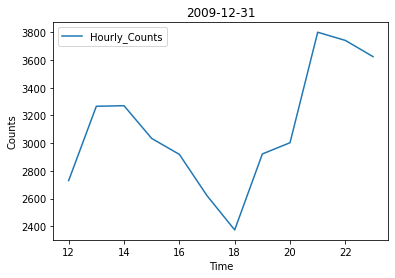

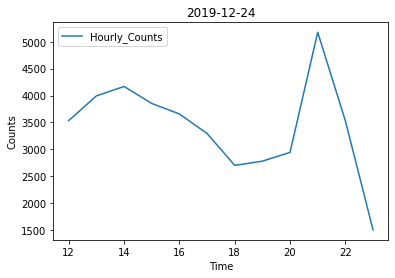

In [13]:
# importing matplot lib to draw result dataset
import matplotlib.pyplot as plt
# importing Window lib from pyspark.sql to use lag functionality on column
from pyspark.sql import Window
# importing sql types
from pyspark.sql.types import StringType
# importing sql functions
from pyspark.sql.functions import *

# Input data frame
df_input = spark.createDataFrame({
    (12, 'increase', ),
    (13, 'increase', ),
    (14, 'increase', ),
    (15, 'decrease', ),
    (16, 'decrease', ),
    (17, 'decrease', ),
    (18, 'decrease', ),
    (19, 'increase', ),
    (20, 'increase', ),
    (21, 'increase', ),
    (22, 'decrease', ),
    (23, 'decrease', )
}, ['Time', 'trend'])

### Algorithm START ###

# function to get trend value as a string converted from Hourly_Count value of row(i) and row(i+1).
# result is based on row(i+1)'s value.
def getTrendValue(cellVal1, cellVal2):
    return 'increase' if cellVal1 < cellVal2 else 'decrease'

# udf function to get cell value from Hourly_Count value of row(i) and row(i+1).
get_trend_val = udf(getTrendValue, StringType())
# udf function to convert datetime object to string value.
convert_date = udf(lambda cellVal: cellVal.strftime('%Y-%m-%d'), StringType())

## Main query
# Steps:
# 1 -> drop not required columns
# 2 -> filter with sensor id = 4 and time between 10 to 24
# 3 -> sort by Date_Time and Time column
# 4 -> select required columns
# 5 -> add new column 'trend' that contains value either 'increase' or 'decrease' based on 
#      previous row and current row's Hourly_Counts value
# 6 -> add new column 'date' that contain string date only from Date_Time column (as we do not require time in group by later)
# 7 -> drop column Date_Time
# 8 -> filter records with time > 11 (to contain input dataframe range 12 to 23)
# 9 -> left outer join this dataframe to diffrent copy(changes column's names) of input dataframe.
# 10 -> add new column 'match' that first partition this dataframe based on Date column and 
#       then compare its records(rows) to input dataframe rows.
# 11 -> filter using match column (match==true) to retrived only matched rows.
# 12 -> drop not required columns.
# 13 -> sort remaining data with Date and Time columns.

df_abstract = df_monthly_pad_count\
    .drop('ID', 'Year', 'Month', 'Mdate', 'Day', 'Sensor_Name')\
    .filter(df_monthly_pad_count.Sensor_ID == 4)\
    .filter(df_monthly_pad_count.Time > 10)\
    .filter(df_monthly_pad_count.Time < 24)\
    .orderBy(df_monthly_pad_count.Date_Time, df_monthly_pad_count.Time)\
    .select(df_monthly_pad_count.Date_Time, df_monthly_pad_count.Time, df_monthly_pad_count.Hourly_Counts)\
    .withColumn('trend', \
                get_trend_val(lag(df_monthly_pad_count.Hourly_Counts, default=0)\
                               .over(Window.orderBy(df_monthly_pad_count.Date_Time)), \
                               df_monthly_pad_count.Hourly_Counts))\
    .withColumn('Date', convert_date(df_monthly_pad_count.Date_Time))\
    .drop('Date_Time')\
    .filter(df_monthly_pad_count.Time > 11)\
    .join(df_input.toDF('time2', 'trend2'), expr('Time = time2 and trend = trend2'), 'left')\
    .withColumn('match', expr(f"count(time2) over(partition by Date) = {df_input.count()}"))\
    .filter('match')\
    .drop('match', 'time2', 'trend2', 'trend')\
    .sort('Date', 'Time')

# print result dataframe by grouping Date. To get all days that have matched input dataframe patterns.
print("Dates for sensor 4 that follows the input trend patterns:")
df_abstract.groupBy('Date').agg(count('*')).select(col('Date').alias('Date (YYYY-MM-dd)')).show(truncate = False)

### Algorithm END ###

# Plotting dataframe's records to see trends of all matched Days. 
print("Trend Analysis of those dates:")
pdf = df_abstract.toPandas()
pdf_1 = pdf.set_index('Time').groupby('Date')['Hourly_Counts']
for date, series in pdf_1:
    series.plot()
    plt.ylabel("Counts")
    plt.legend(['Hourly_Counts'])
    plt.title(date)
    plt.show()

<a class="anchor" name="three"></a>
# Performance Analysis
<a class="anchor" name="threeone"></a>
## 3.1 Performance Comparision
<a class="anchor" name="threeoneone"></a>
### 3.1.1 Screenshots of Spark UI for question 1.2.3 and 2.2.2 

### Job information For Question 1.2.3 : Top-5 Sensor data display using RDD
* [Link to -> 1.2.3 Top-5 Sensor data display [RDD]](#onetwothree)
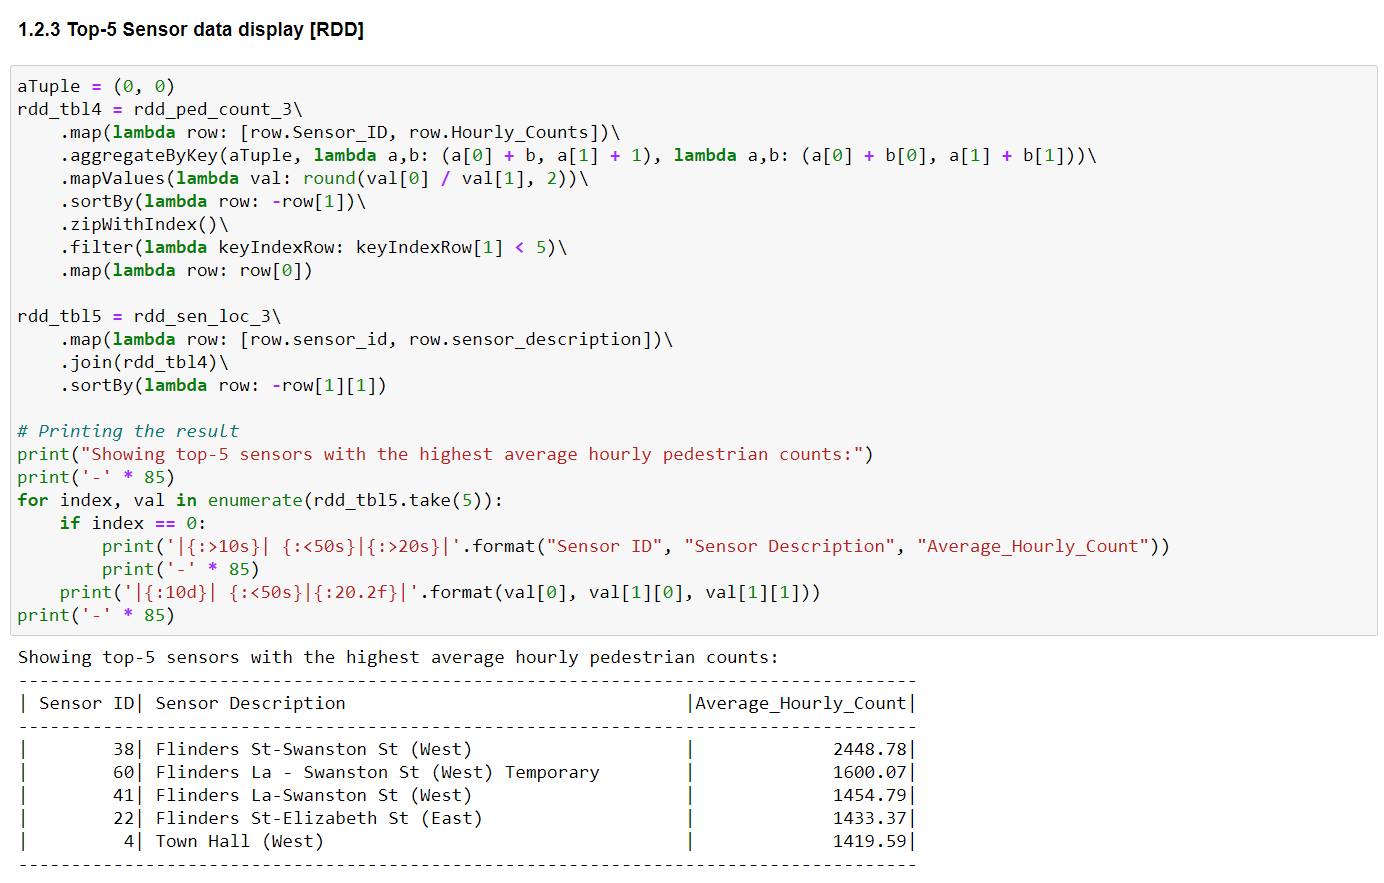
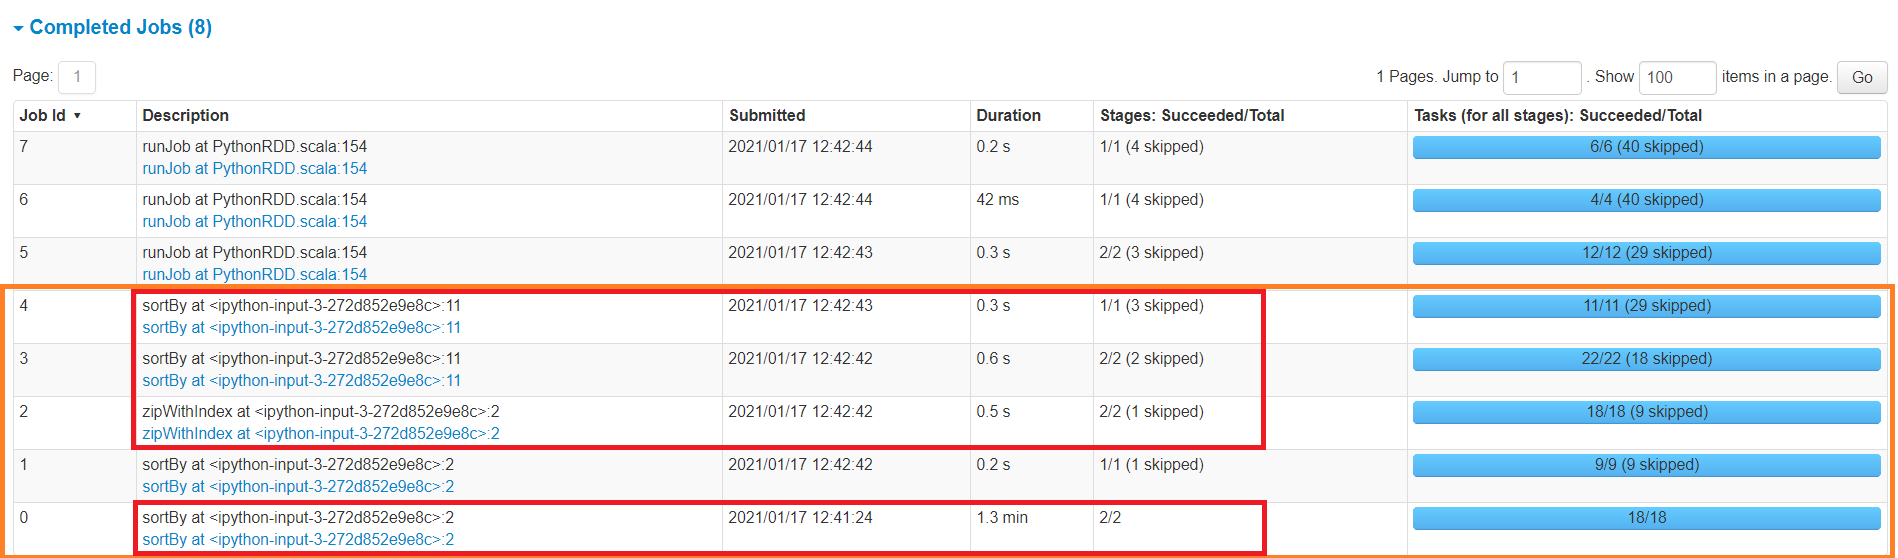
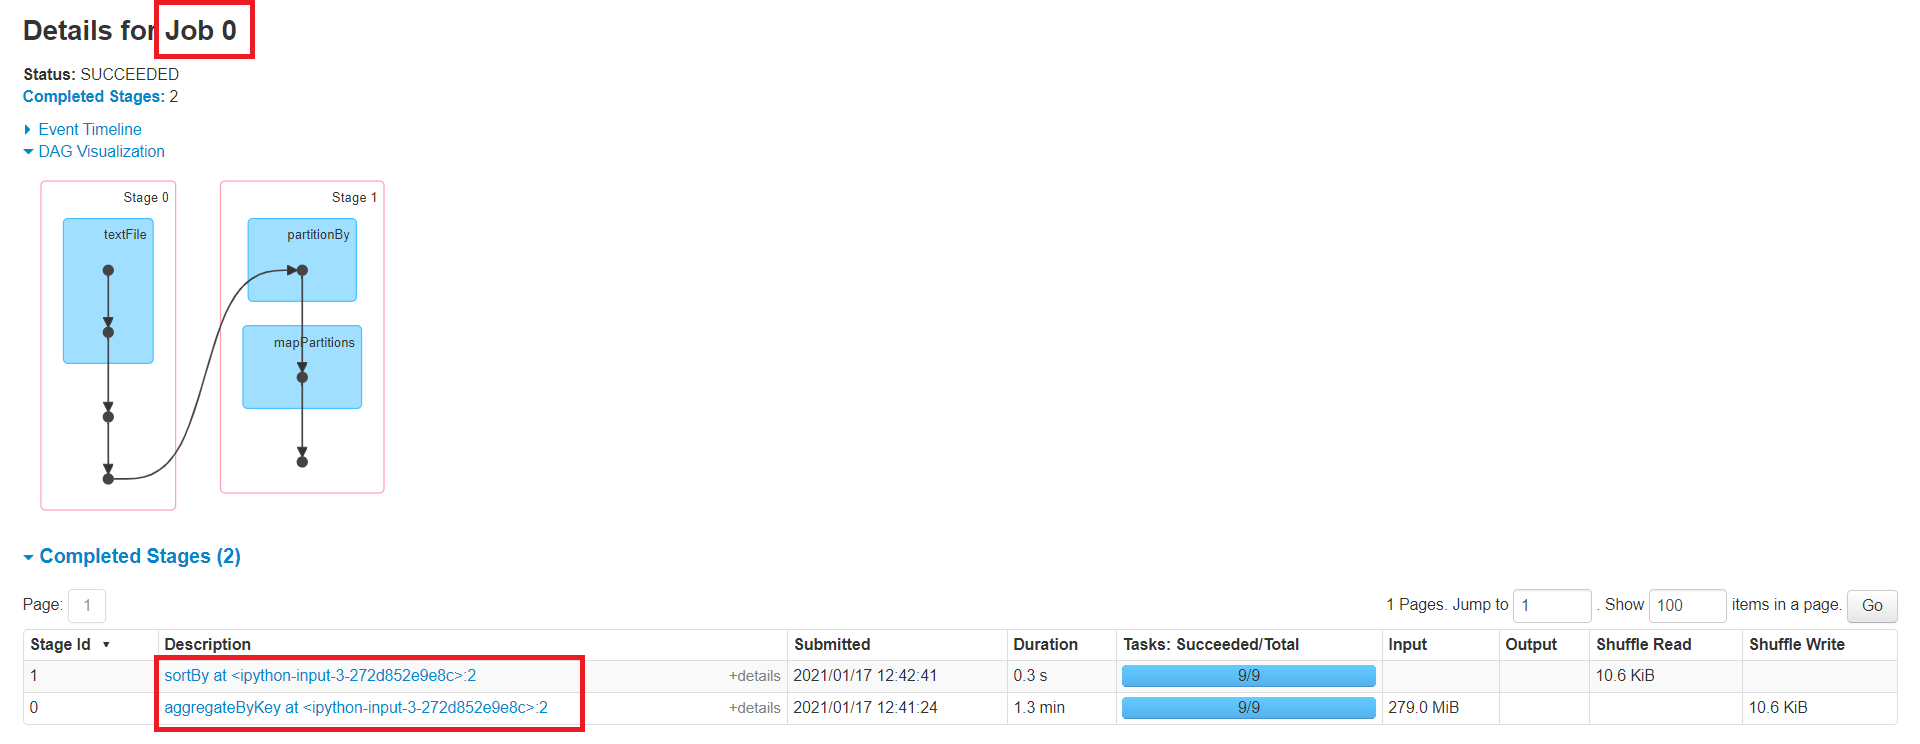
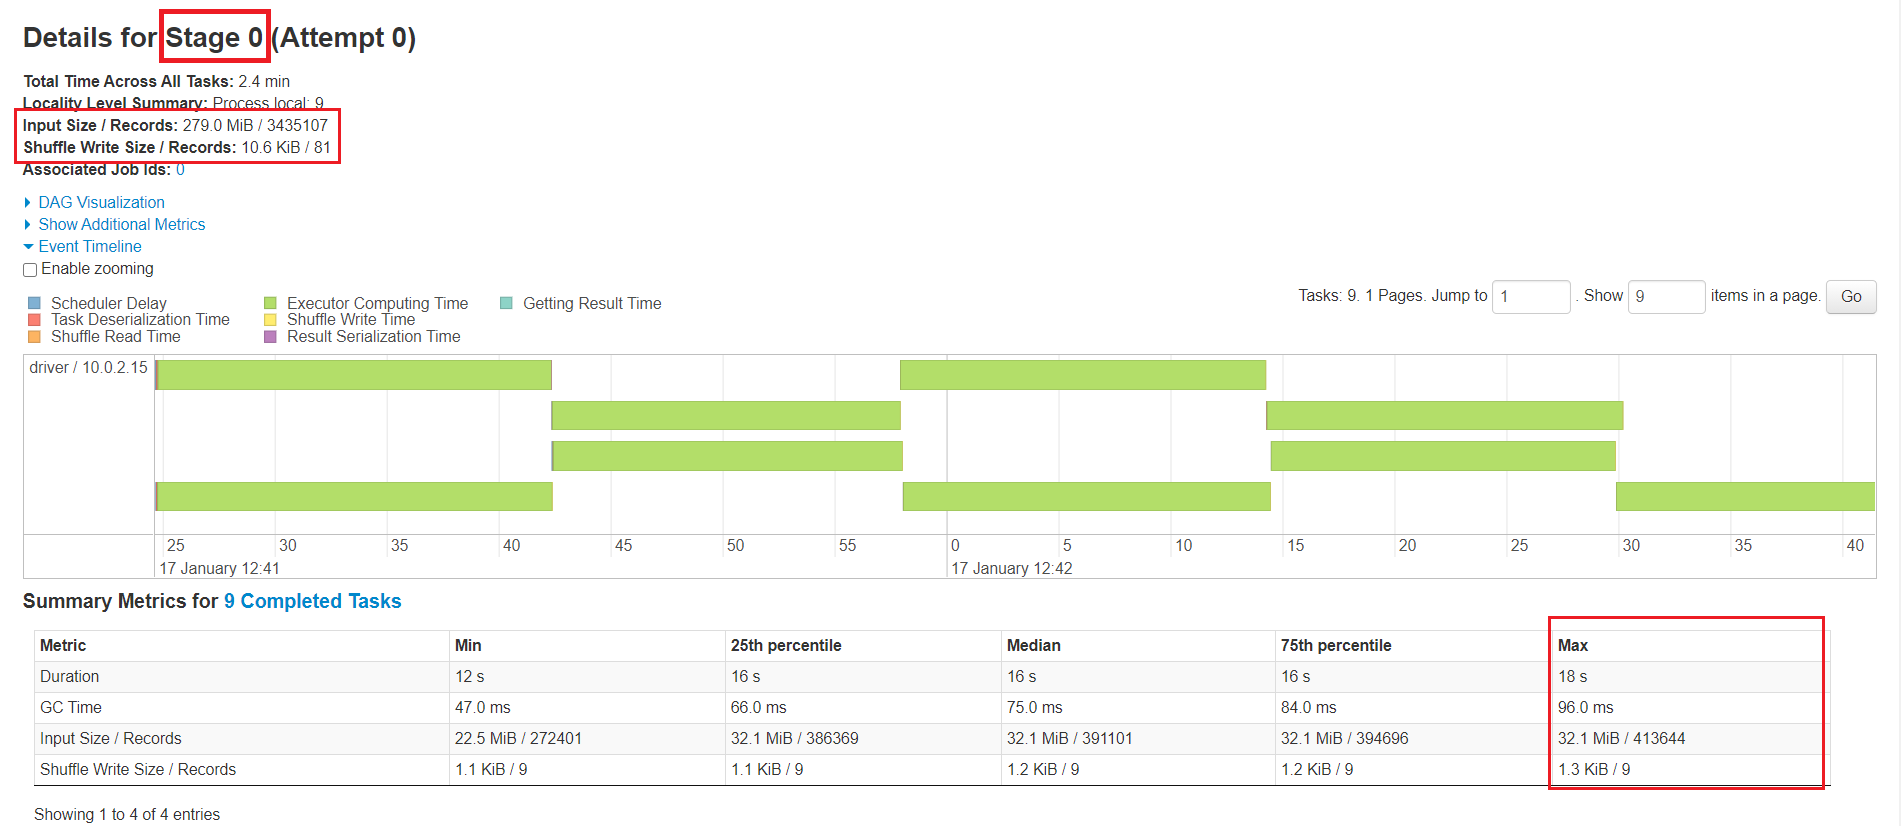
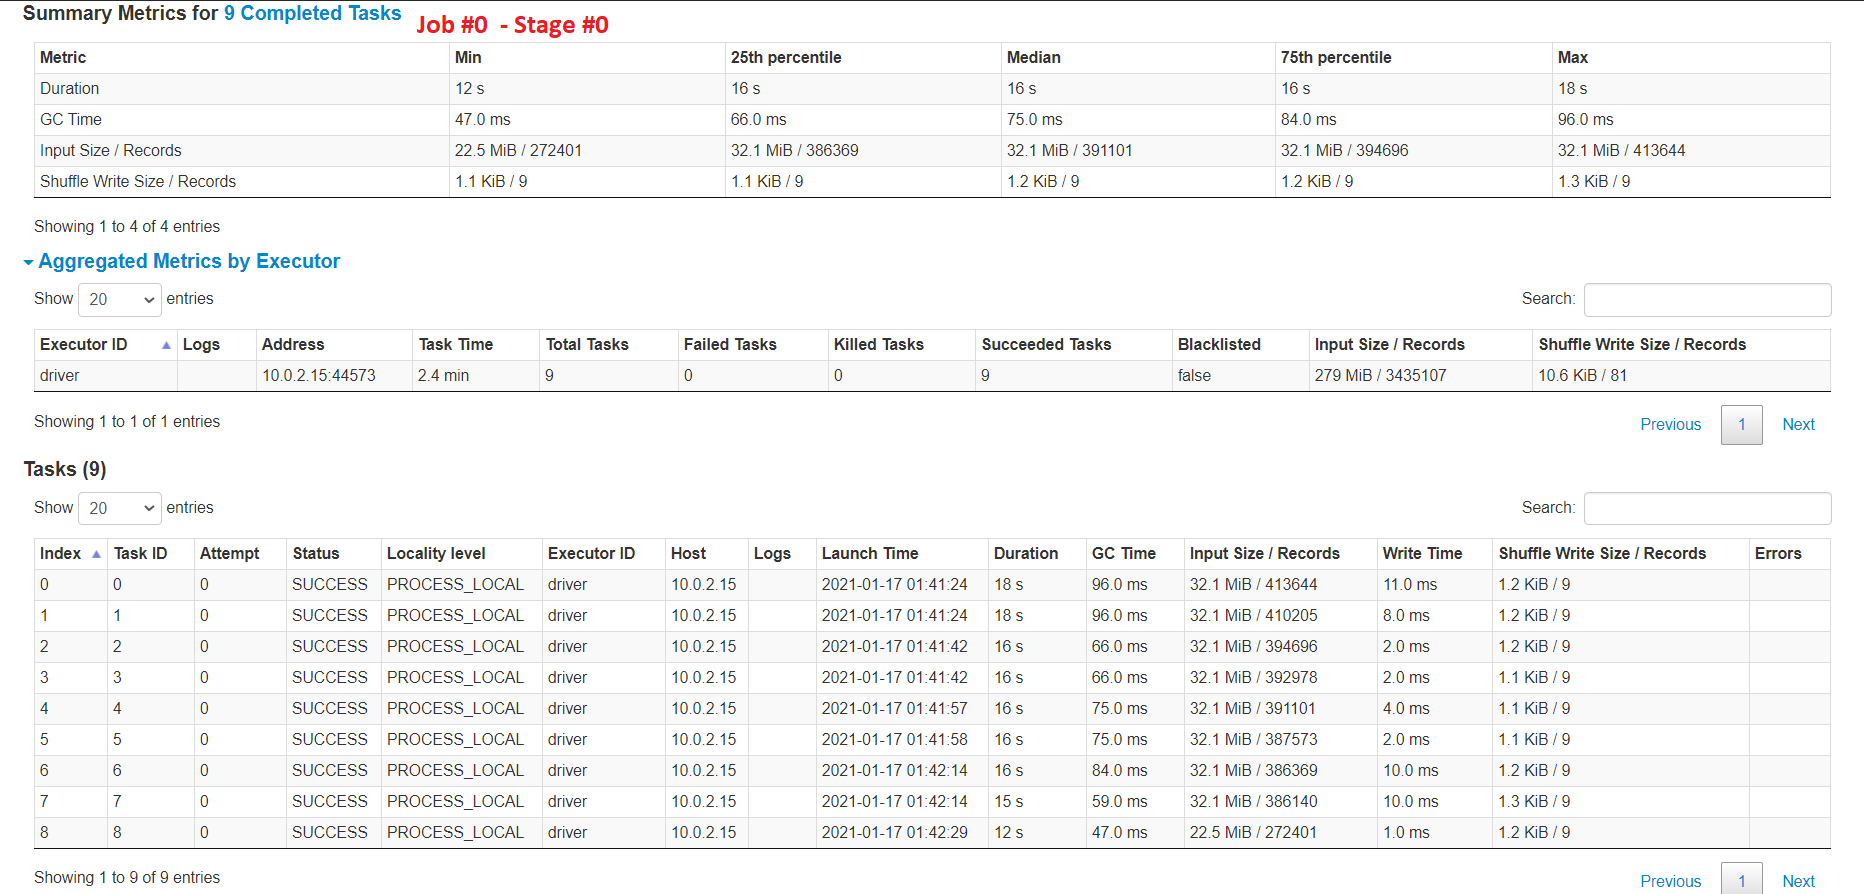
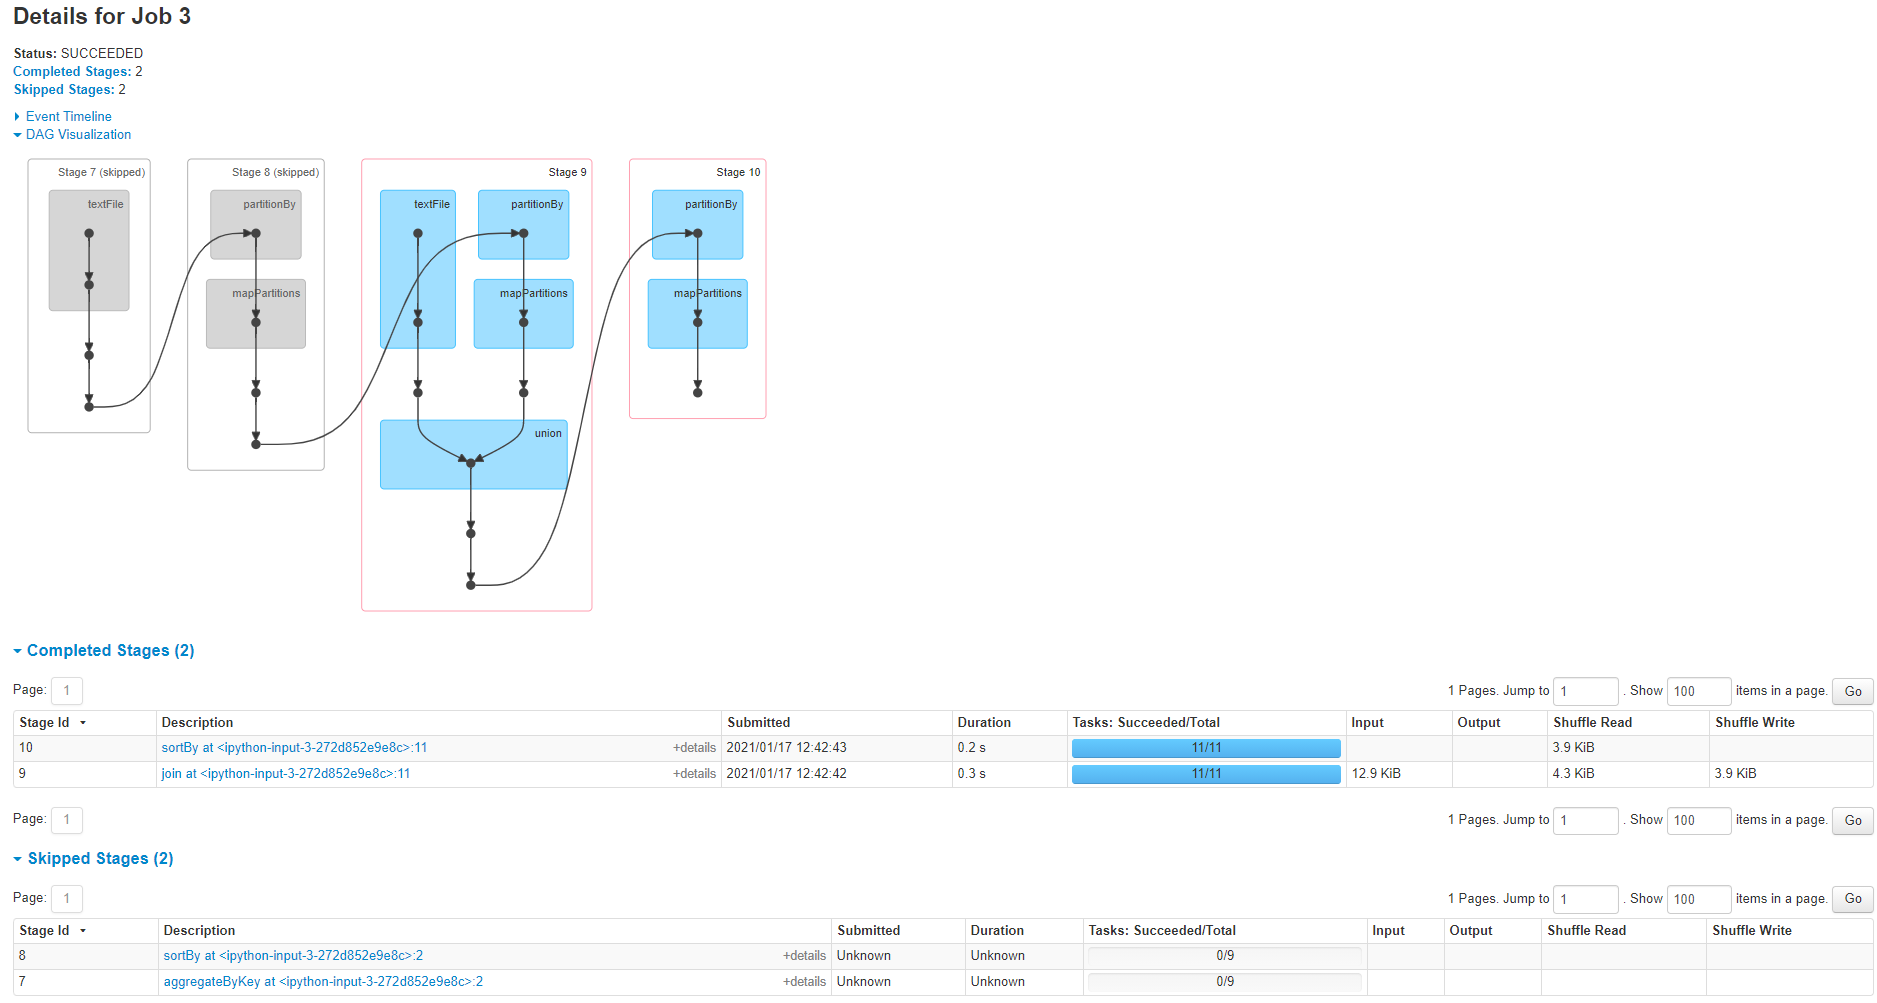
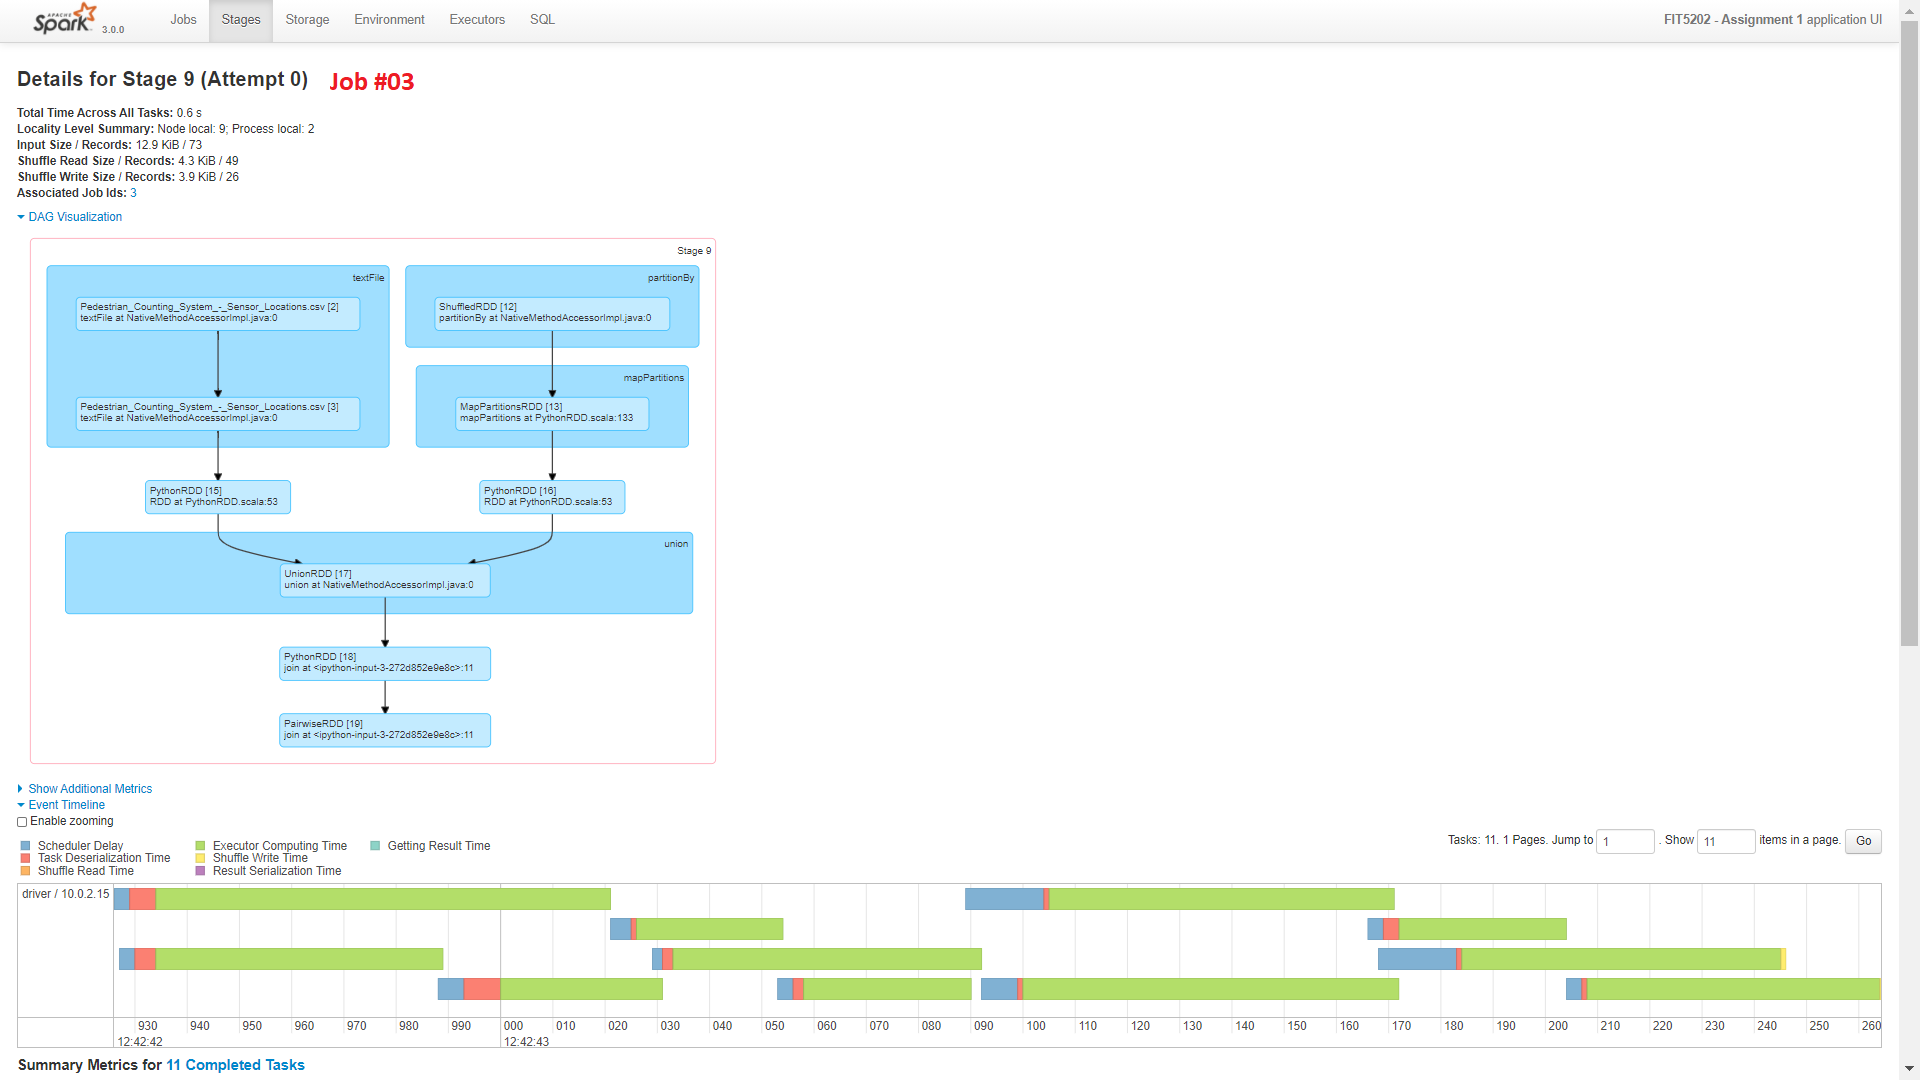
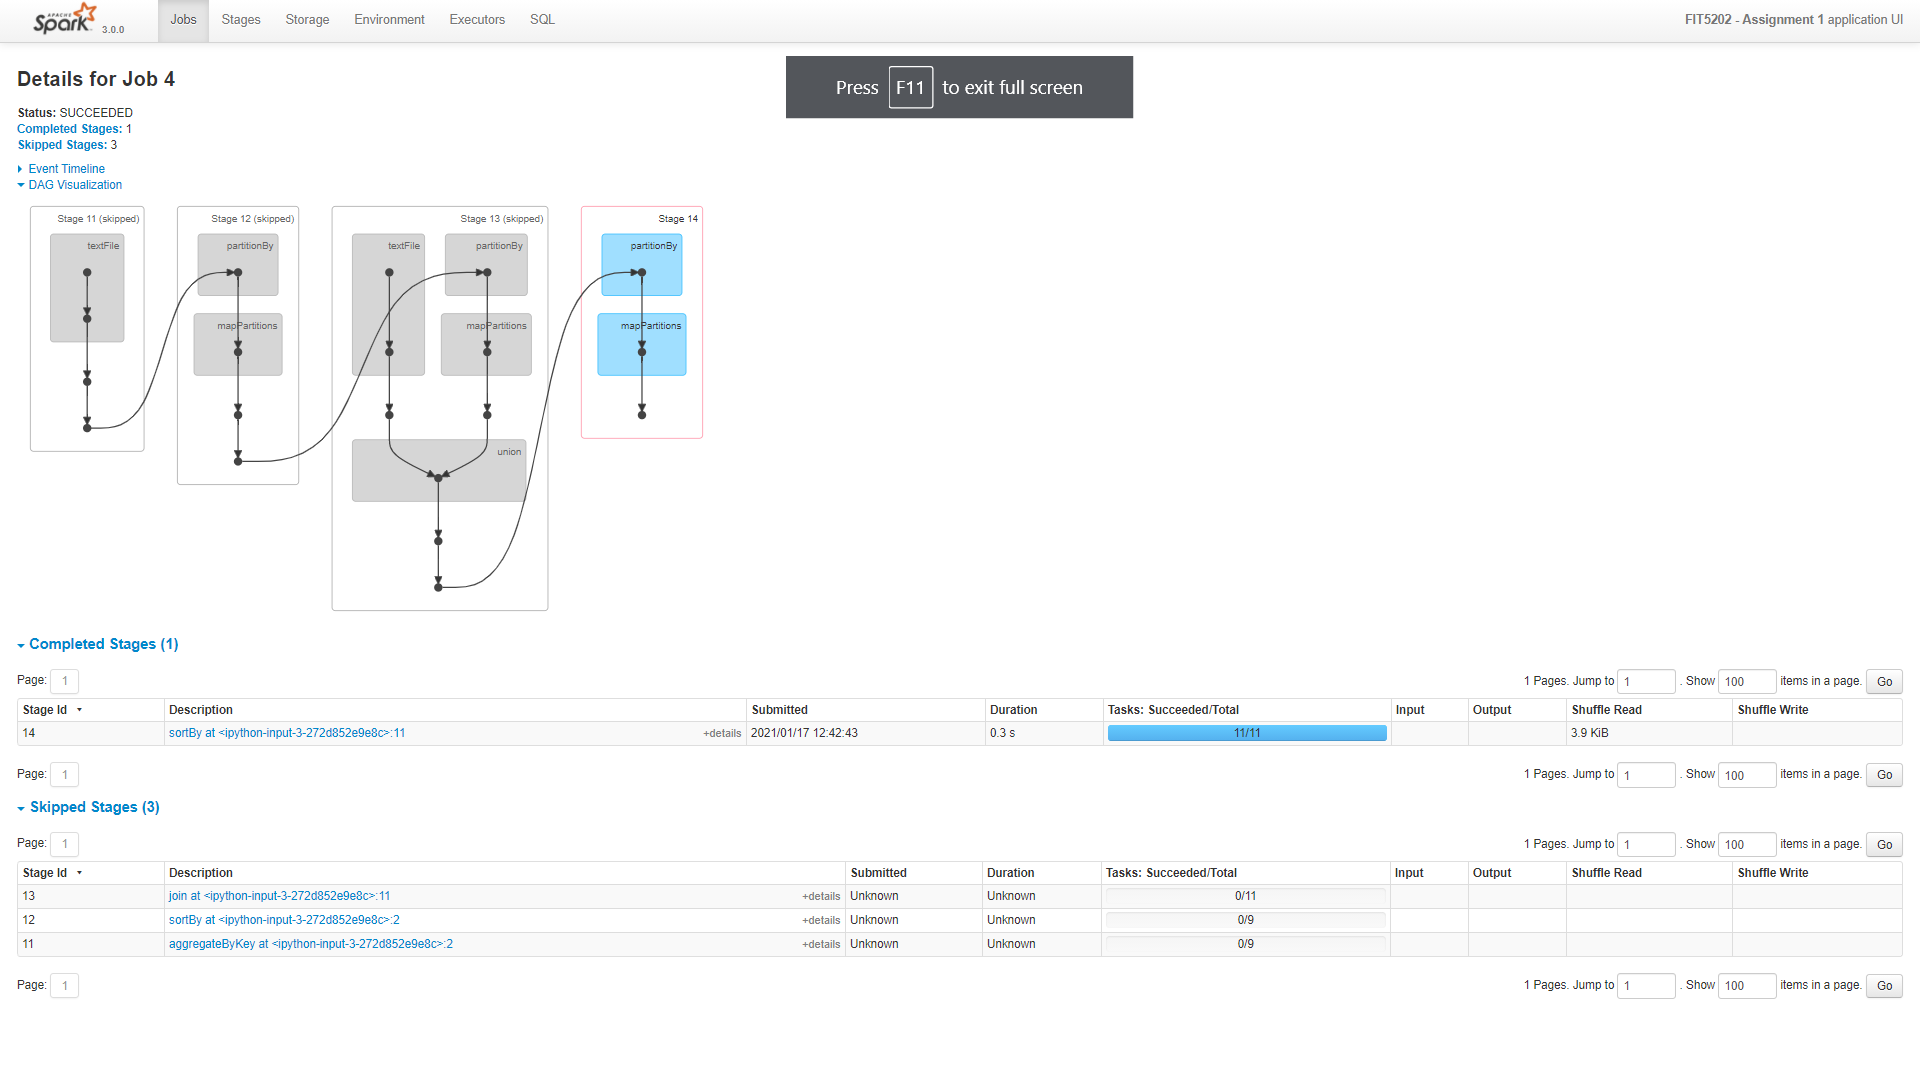
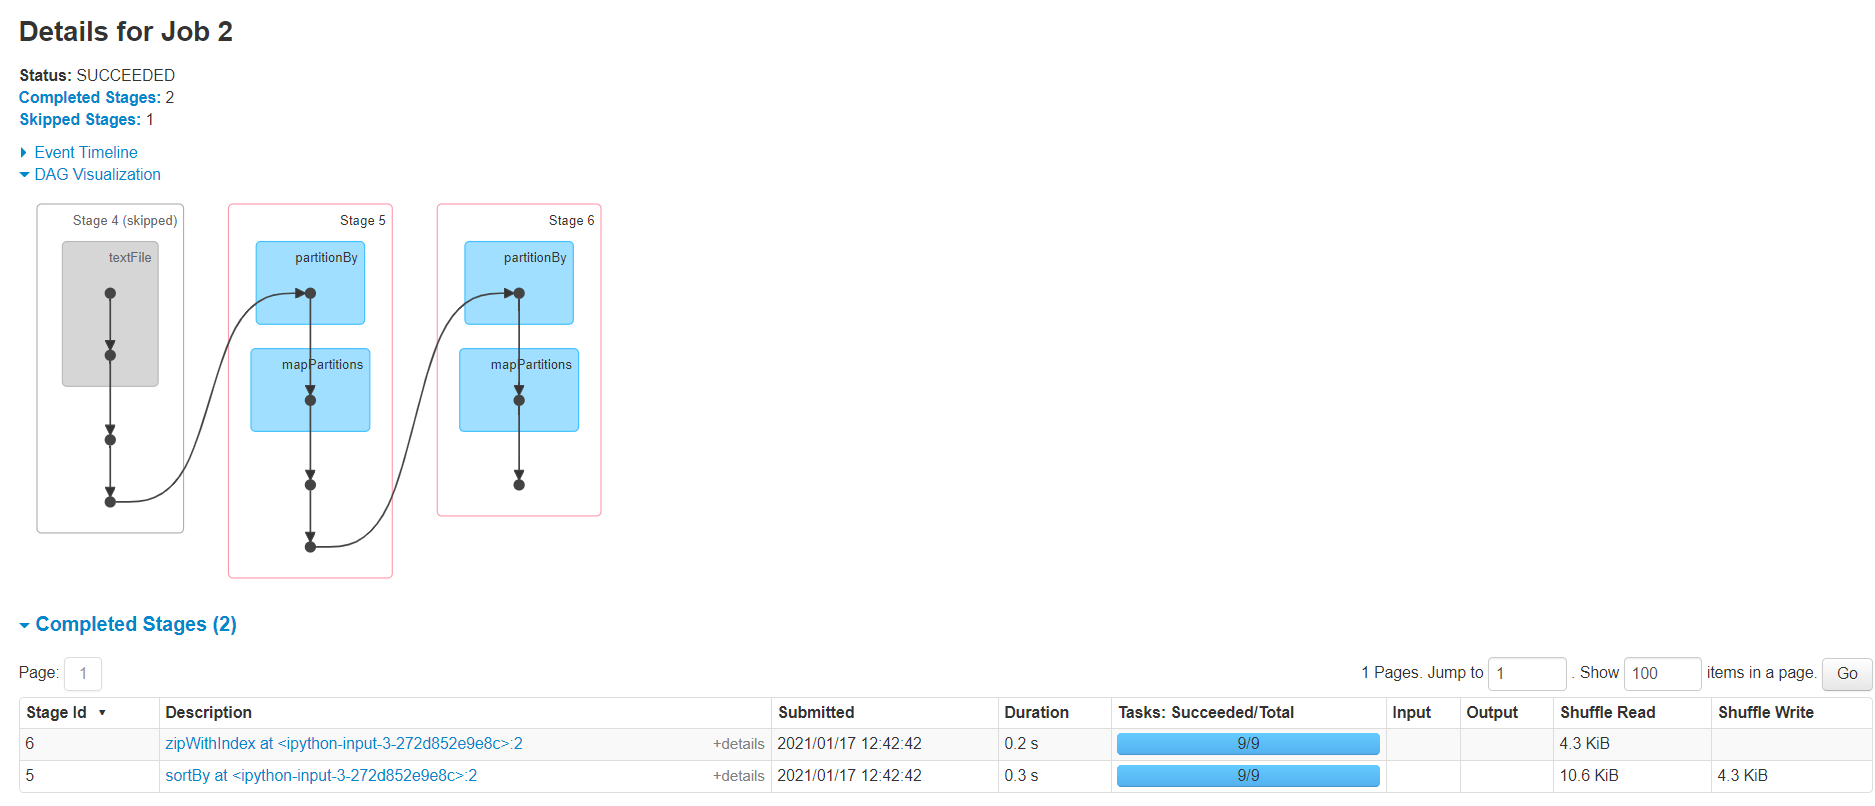

### Job information For Question 2.2.2 : Top-5 Sensor data display using DataFrames
* [Link to -> 2.2.2 Top-5 Sensor data display [DataFrames]](#twotwotwo)
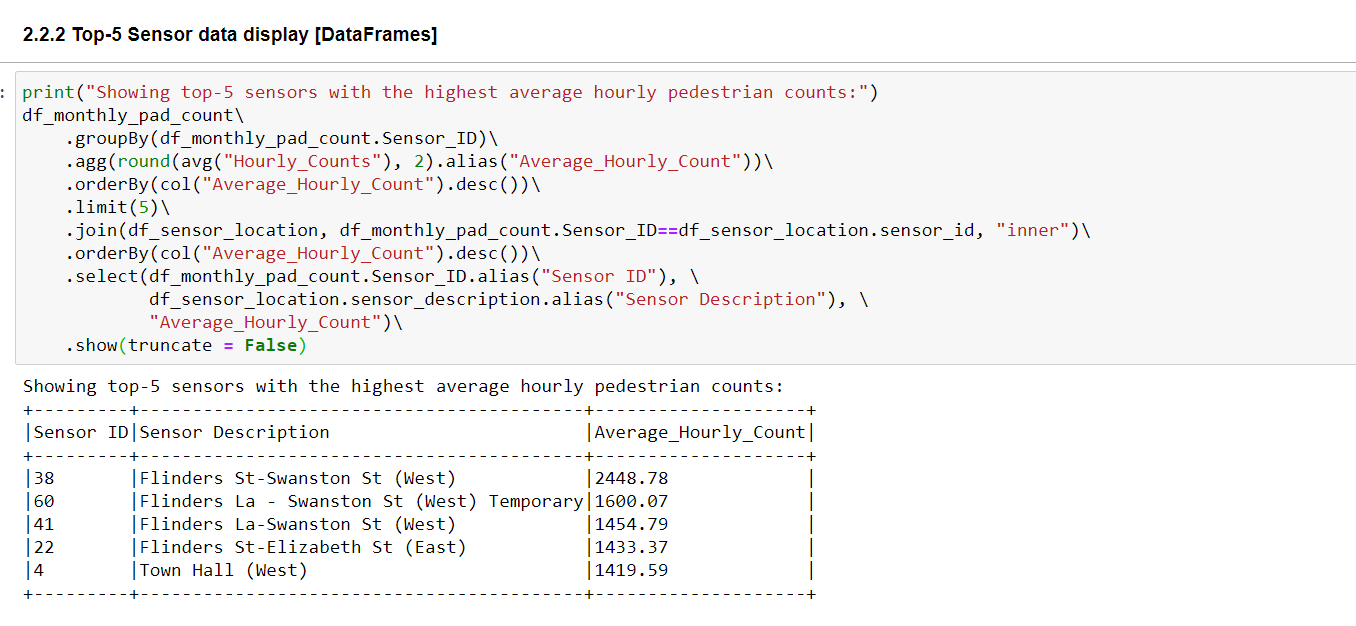
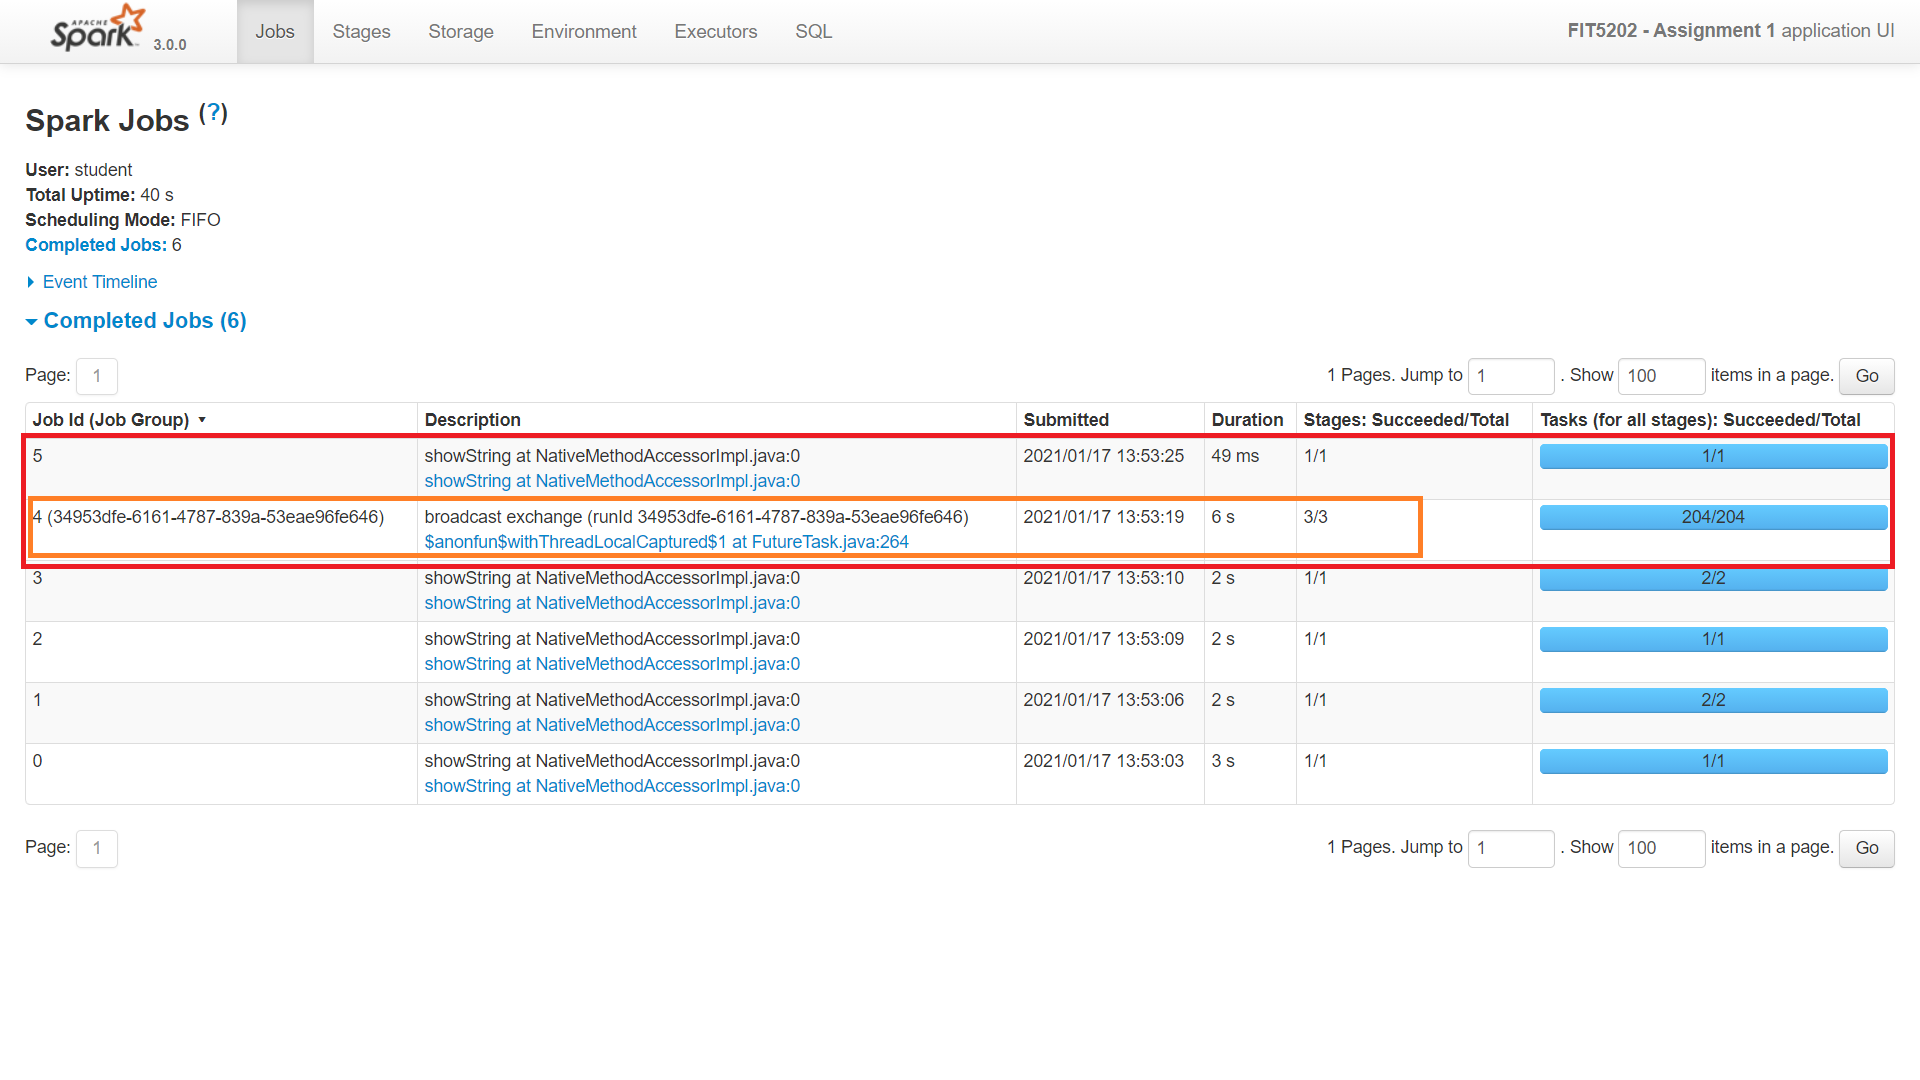
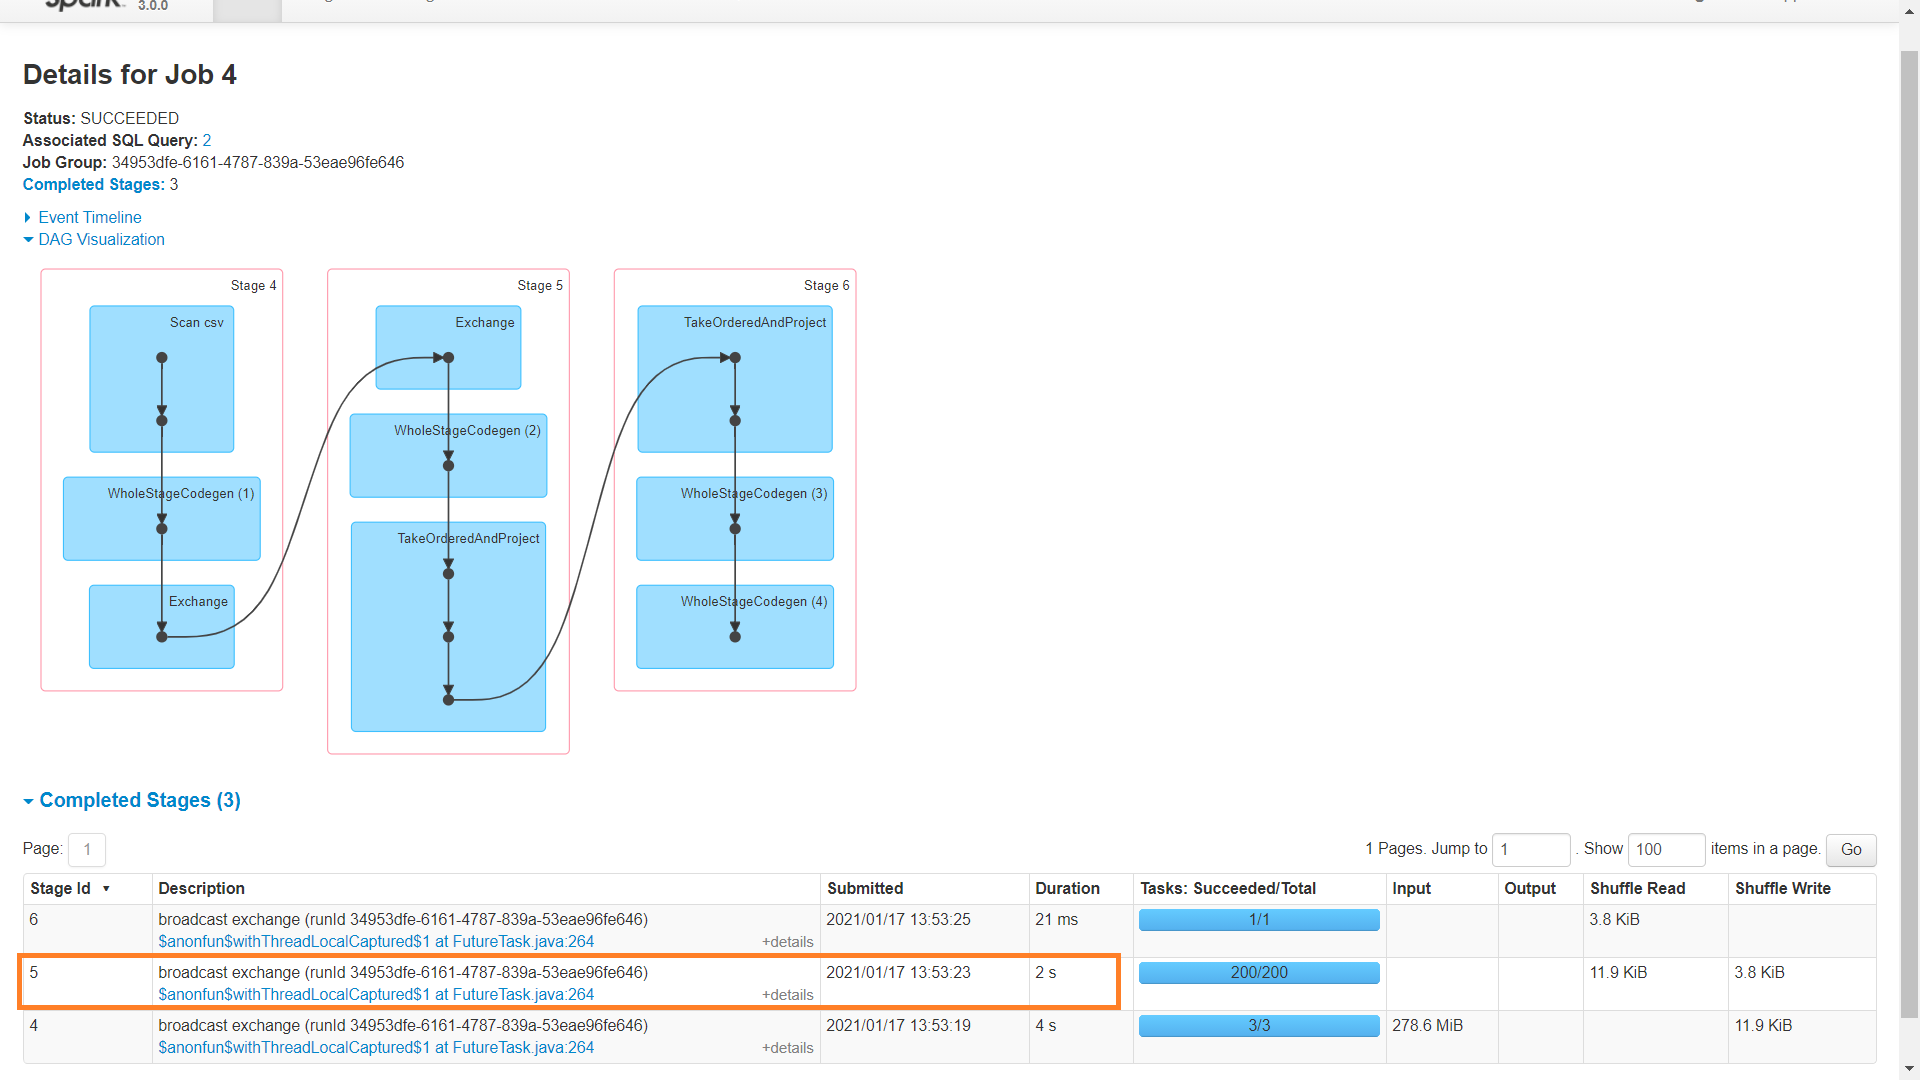
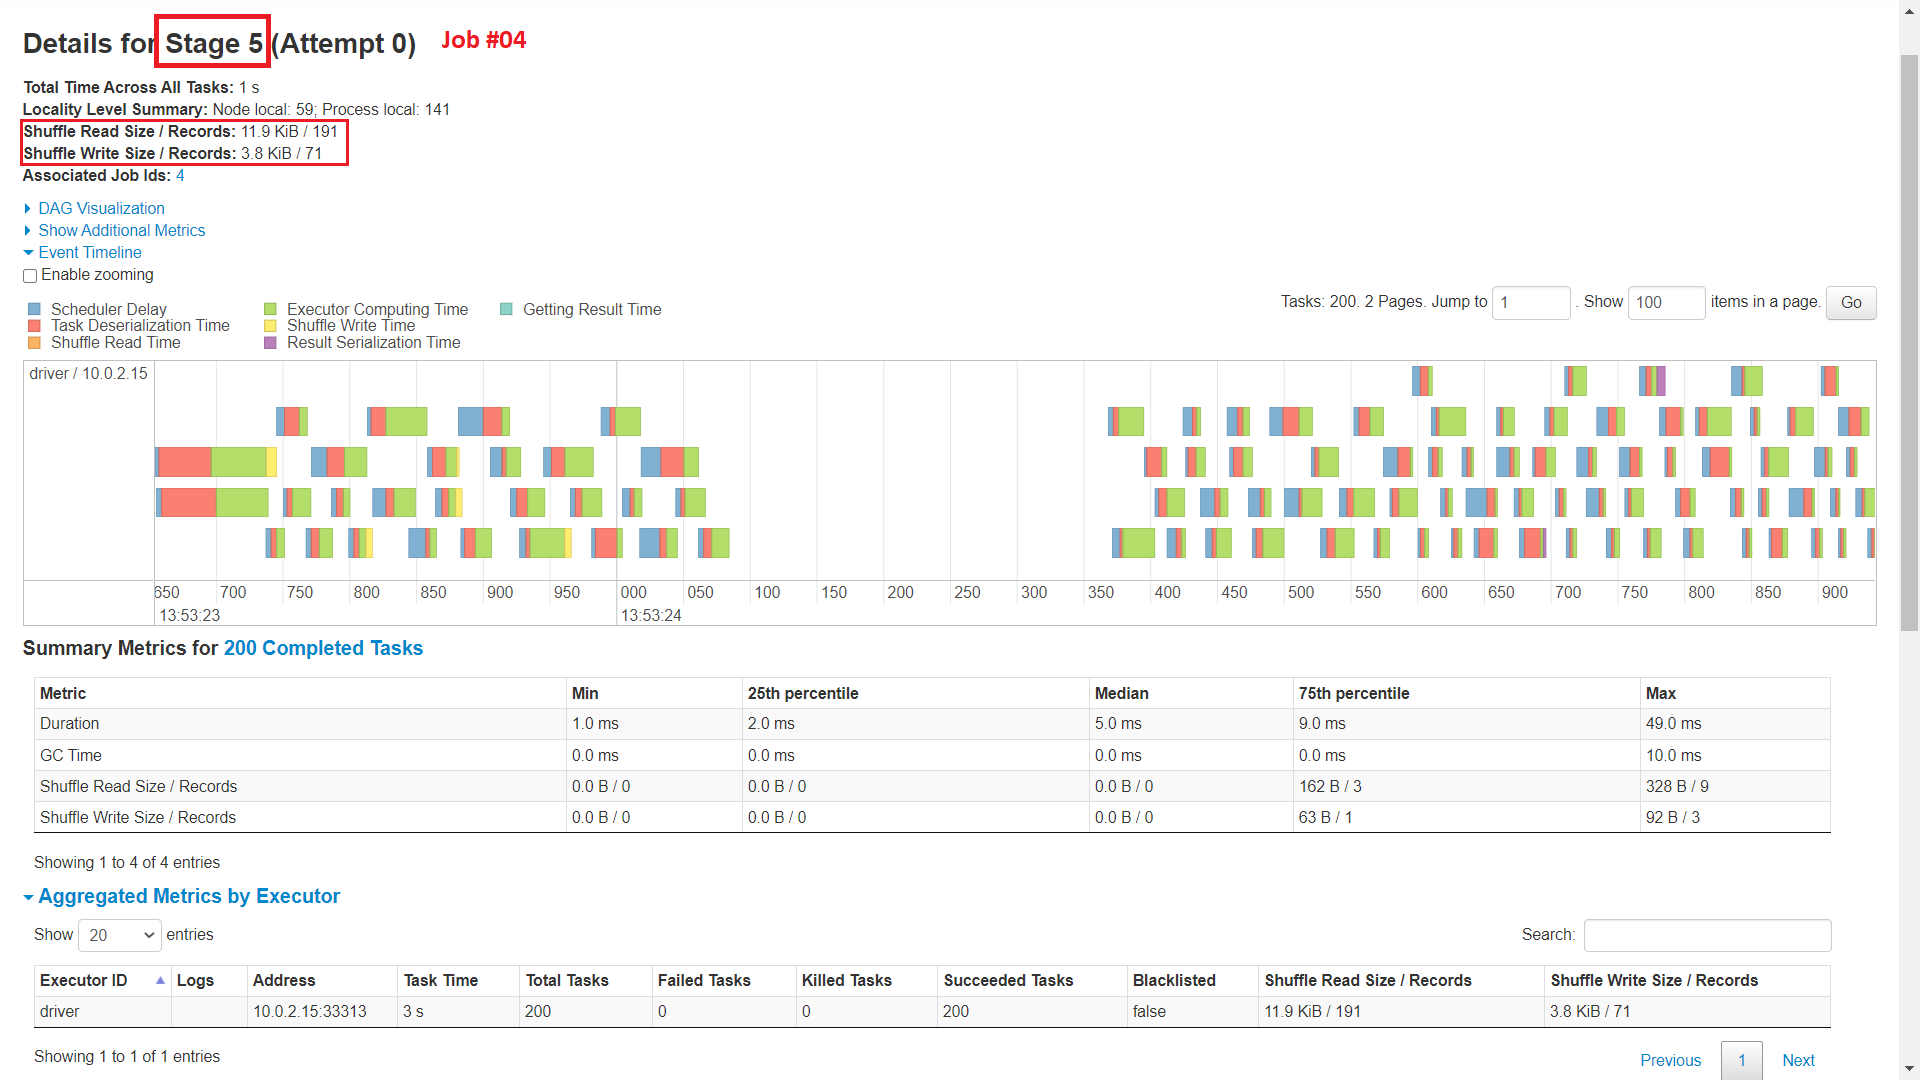
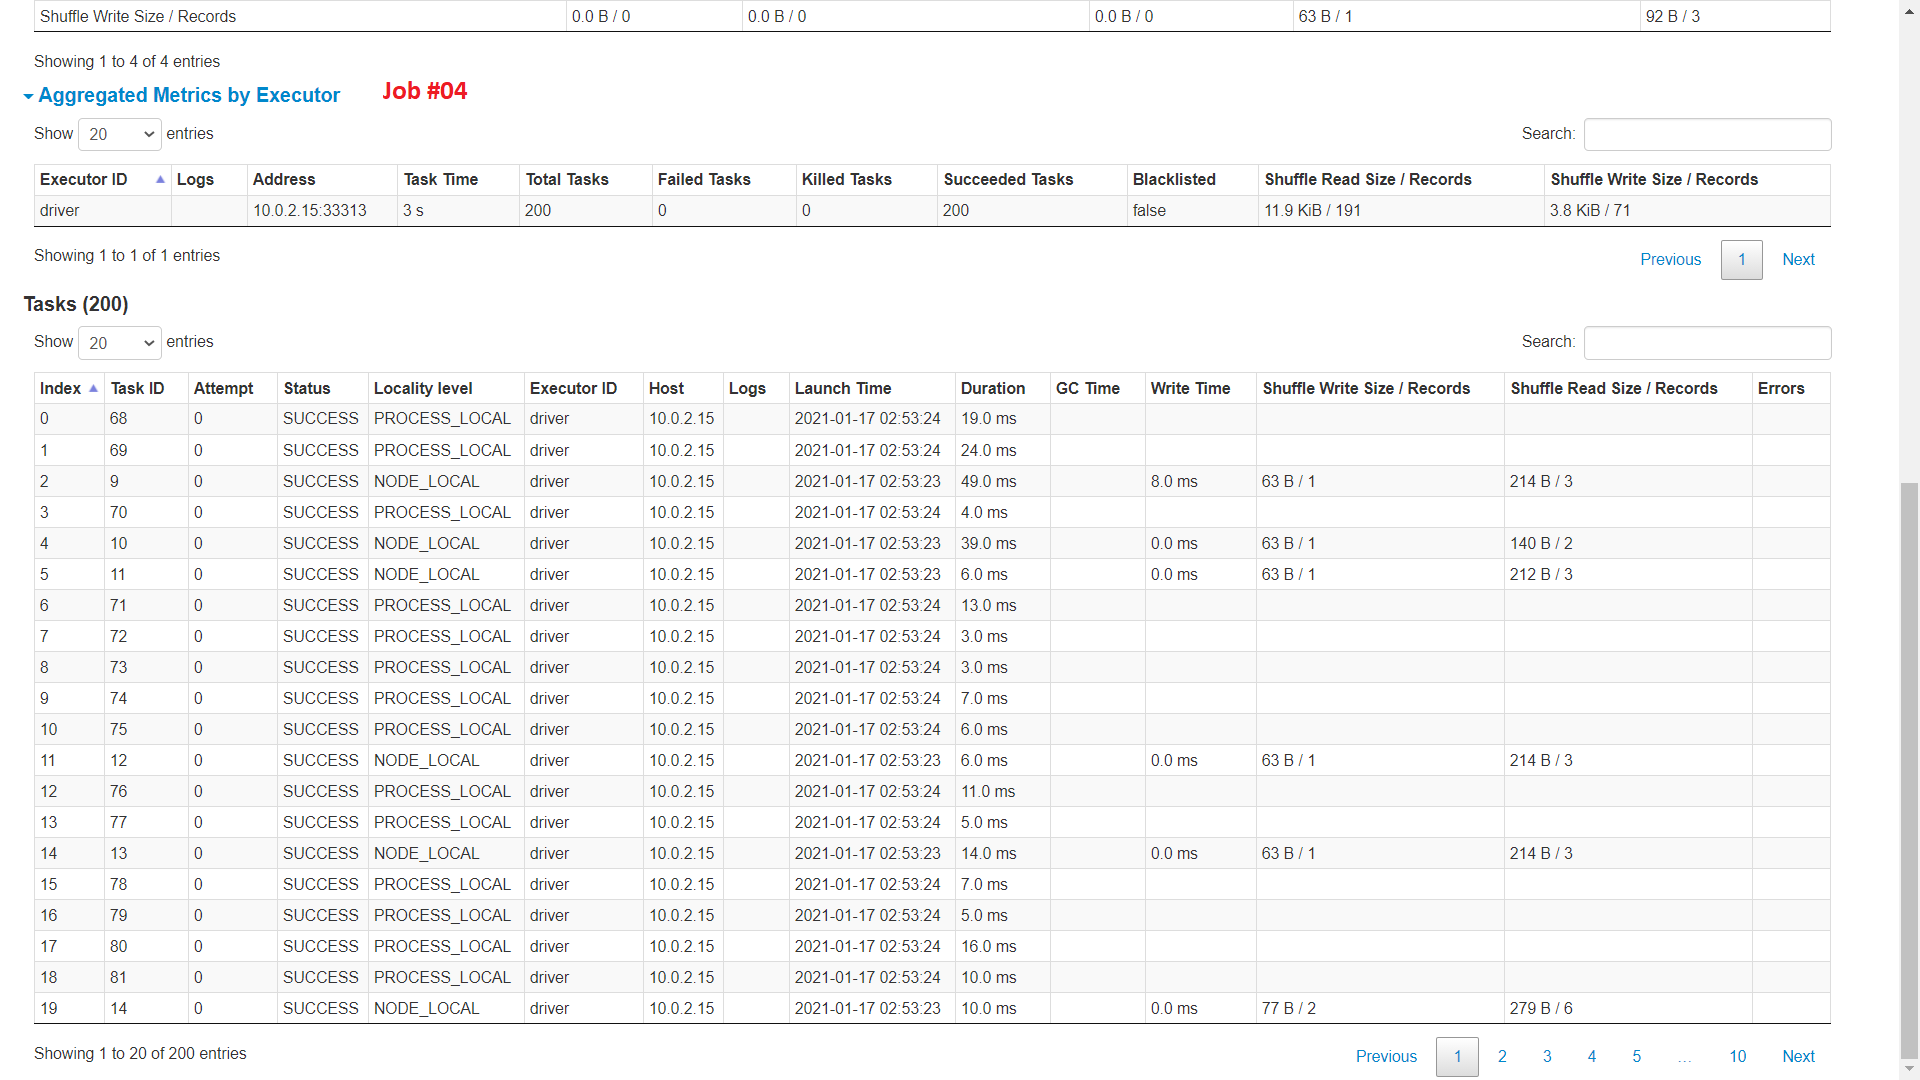

<a class="anchor" name="threeonetwo"></a>
### 3.1.2 Comparision explanation

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE">3.1.2: </strong>Faster run time between 1.2.3 and 2.2.2 
    <ul>
        <li>Job run in Q_2.2.2 is faster than Q_1.2.3, means using <strong>DataFrame is faster</strong> then retriving same result using RDD.</li>
        <li>The <code>aggregateByKey() and sortBy()</code> operation takes much longer time in rdd operations.</li>
        <li>Dataframes are wrapper over RDD with <strong>in-built optimization</strong> on structured or semi-structure data. RDD does not hold any optimization techniques for structured data.</li>
        <li>Here, dataframes use all <strong>200 partiotions</strong> to preform job like <code>join(), aggregations, row ordering</code></li>
        <li>while RDD goes with default(==9) or pre-define(==4) partition size, here it also incur cost of coalesce (repartition from default to 4 partition).</li>
        <li>If we perform RDD operation with >40 partition, it runs slower then with default partitions as a cost of more data shuffling and repartitioning.</li>
        <li>With the case of DataFrame, its default partition plan is optimized with respect to query and use all availalbe partitions. And because of this, shuffling write data is far less compare to RDD.</li>
    </ul>
</div>

<a class="anchor" name="threetwo"></a>
## 3.2 Performance Improvement
<a class="anchor" name="threetwoone"></a>
### 3.2.1 Screenshots of Spark UI - SQL tab for Question 2.2.4

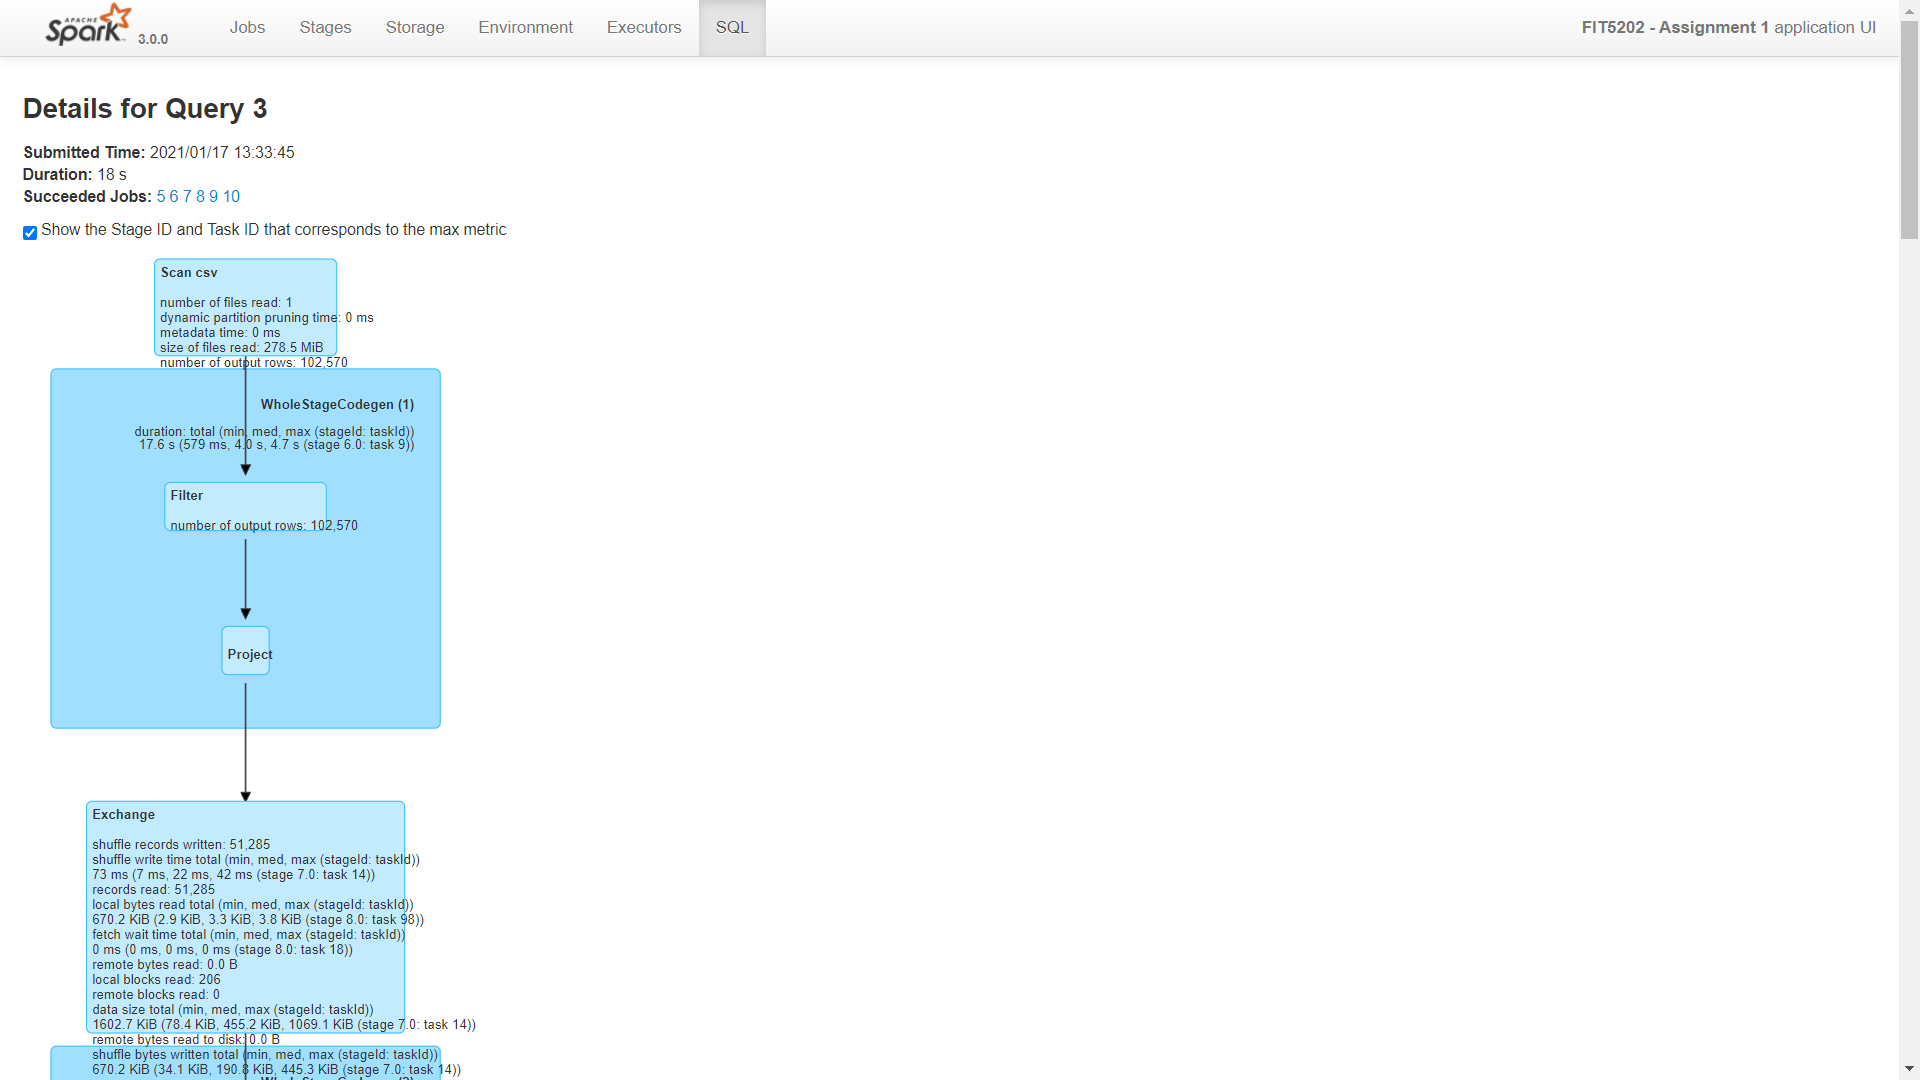
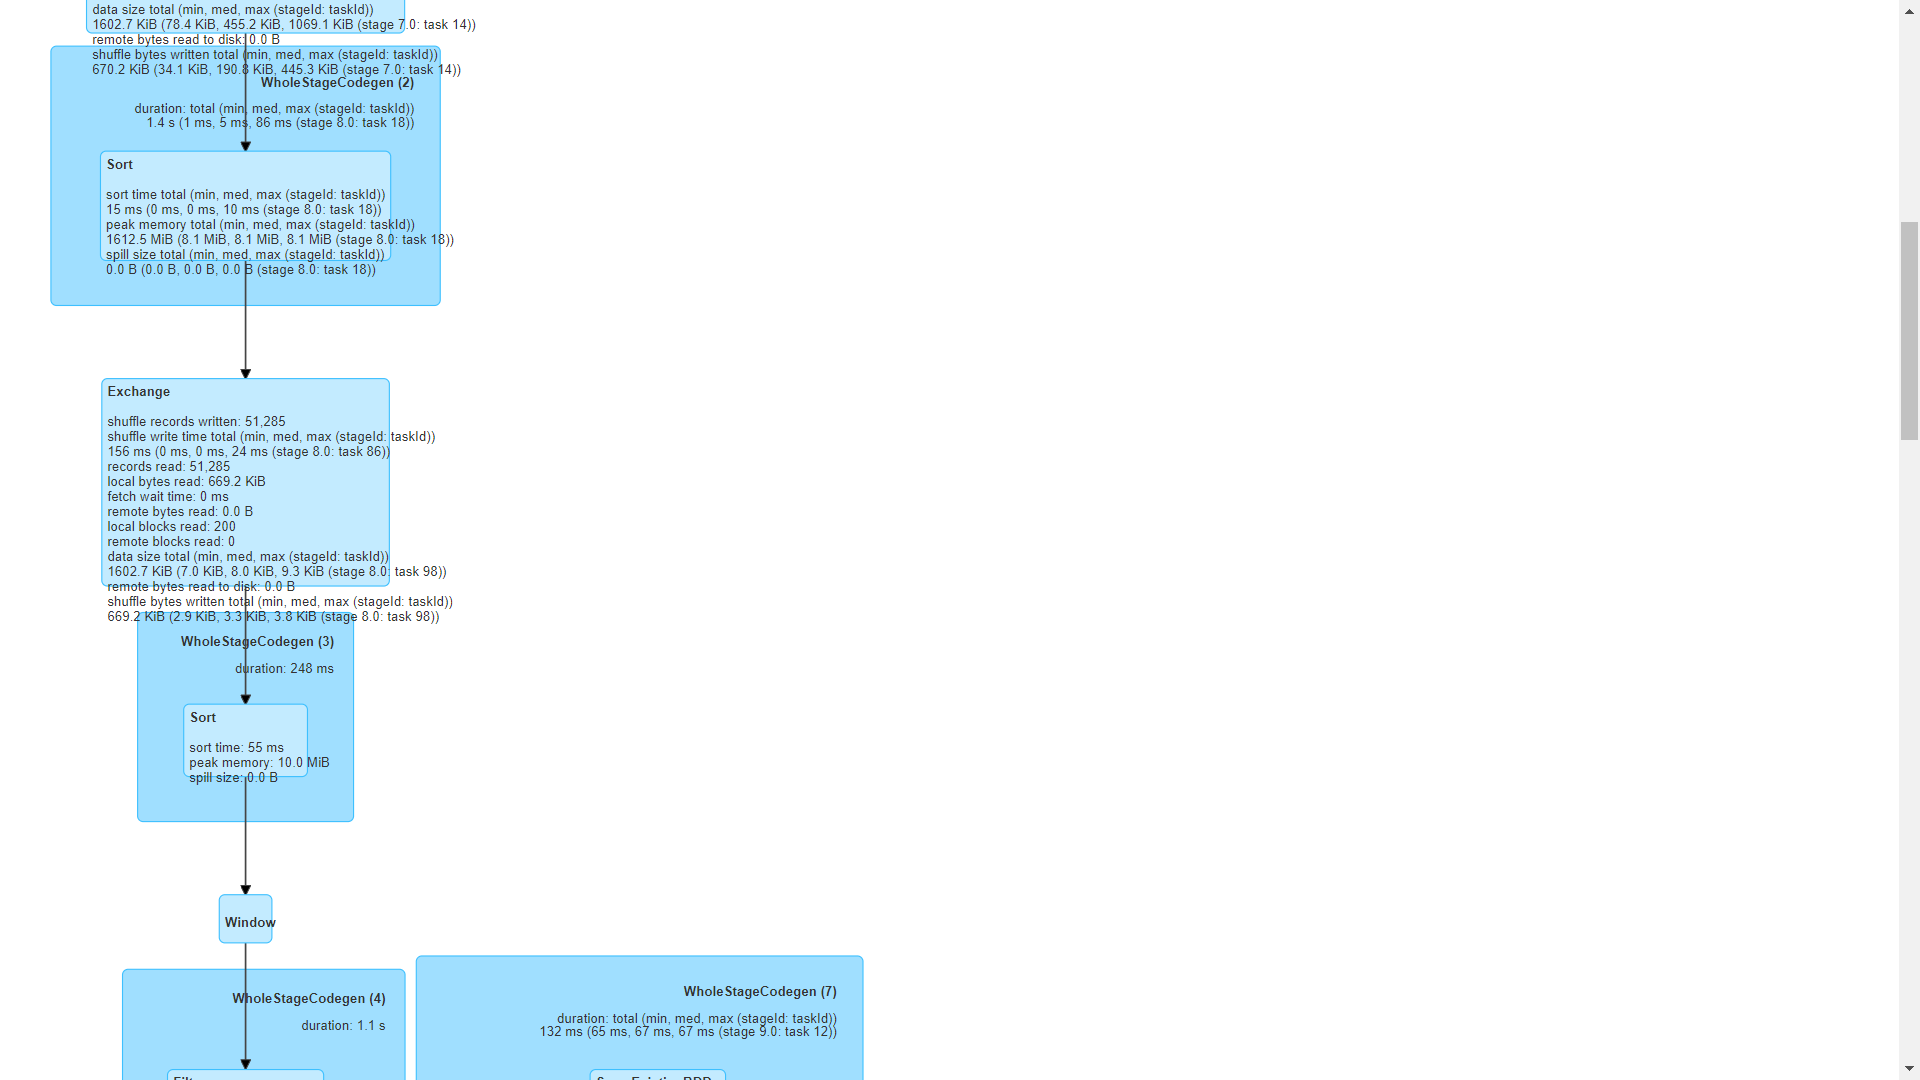
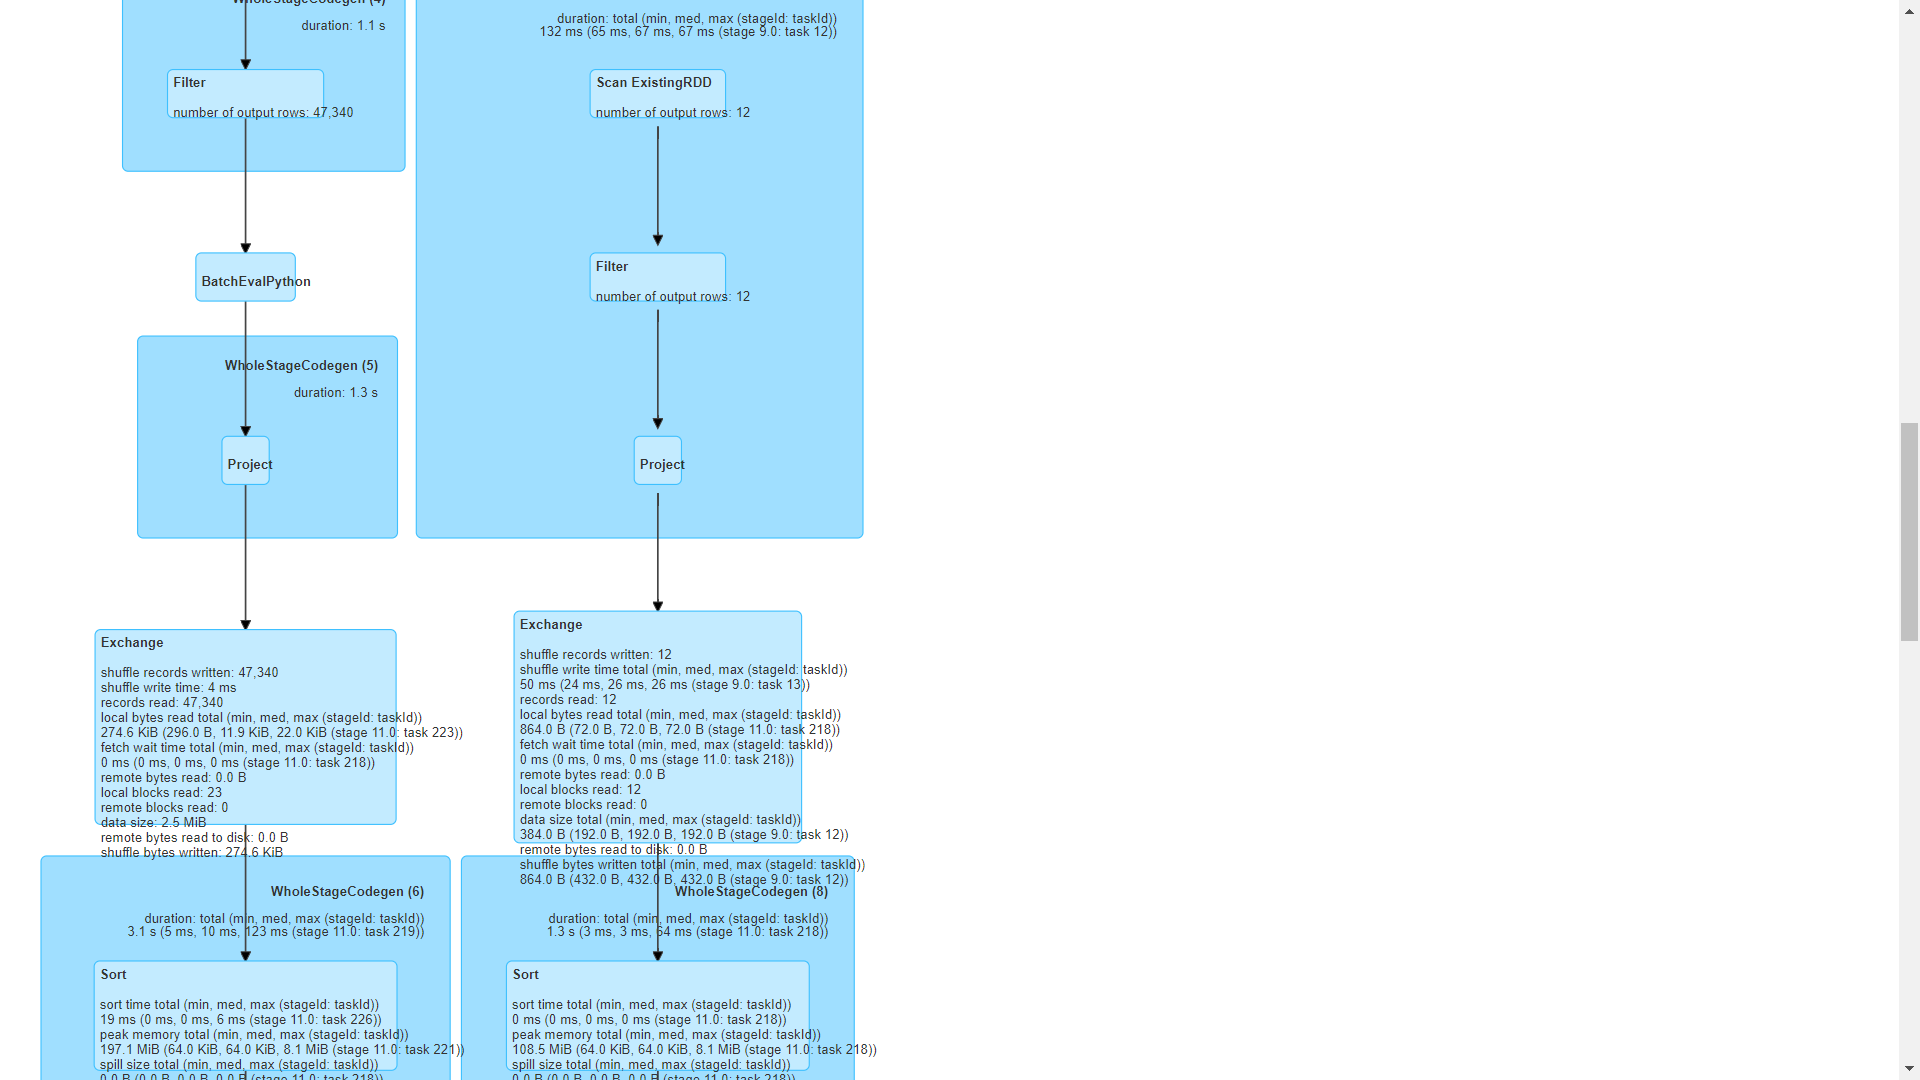
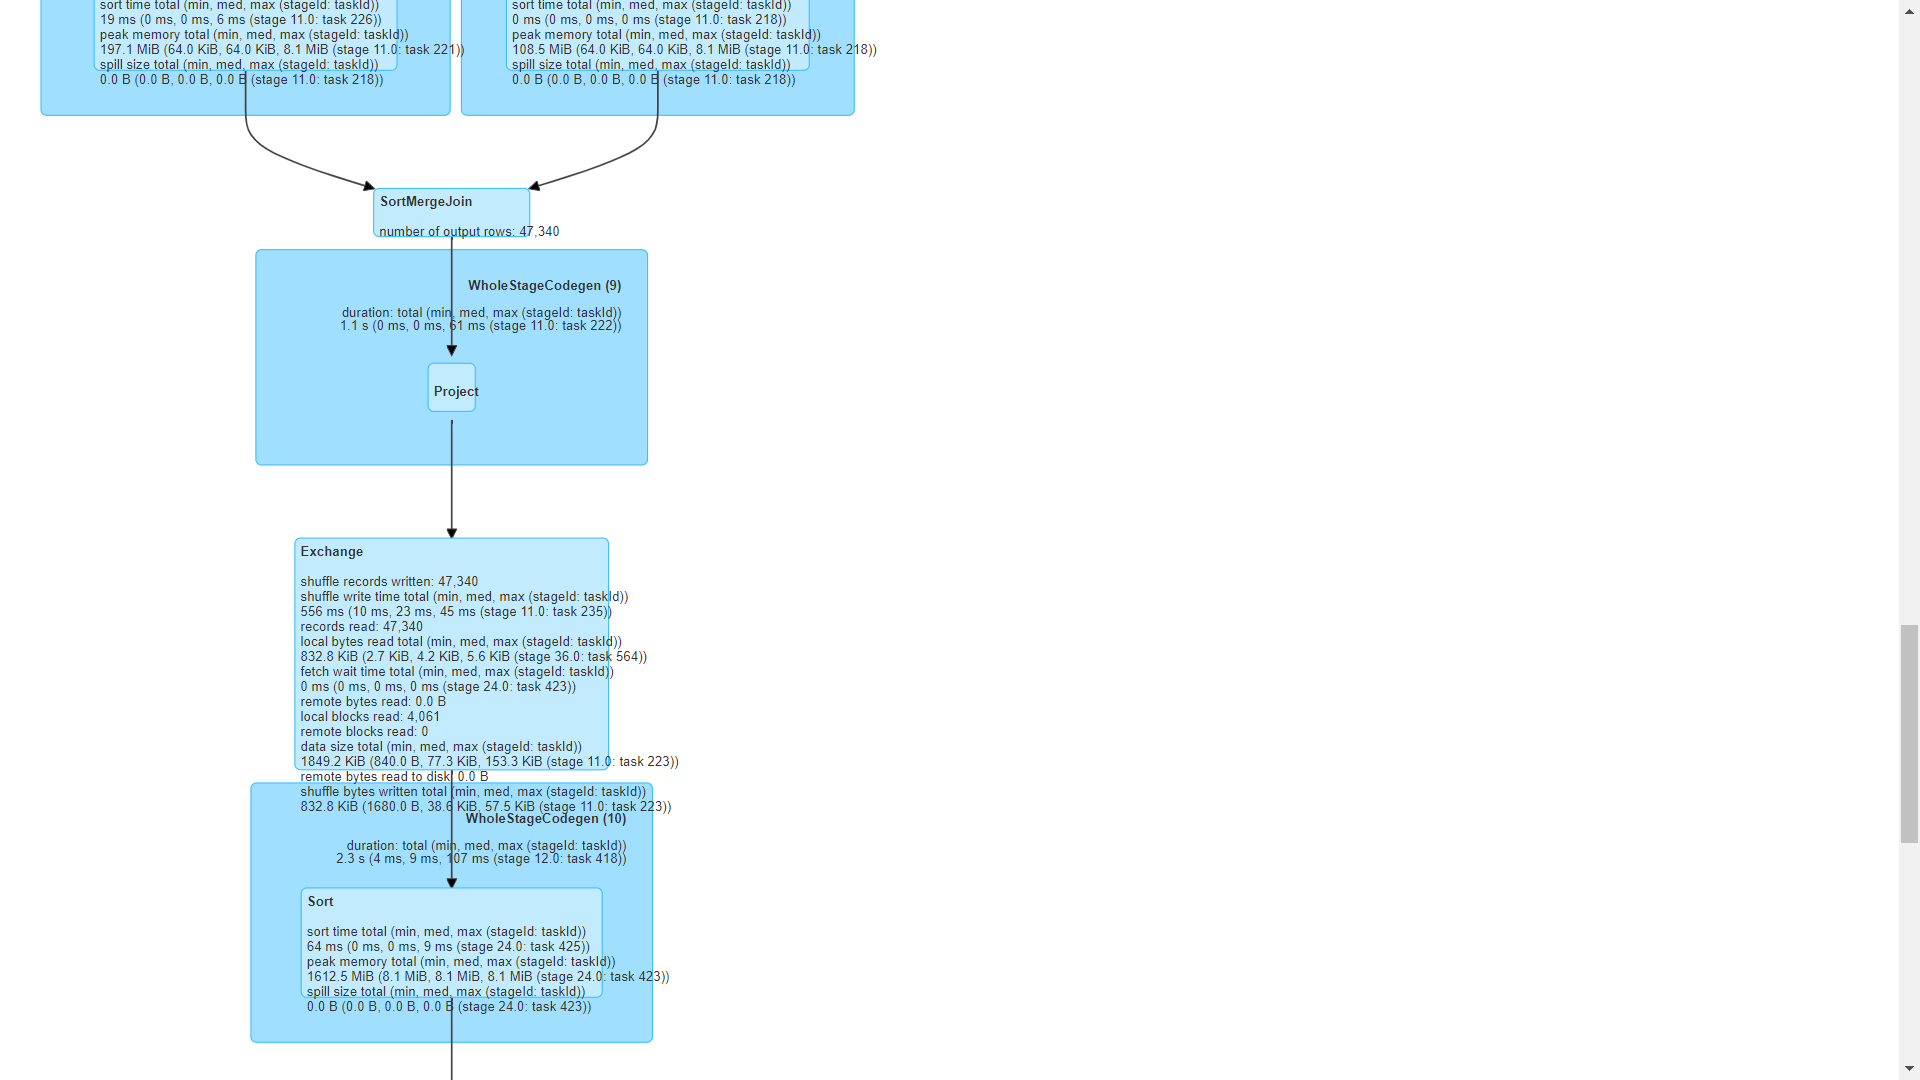
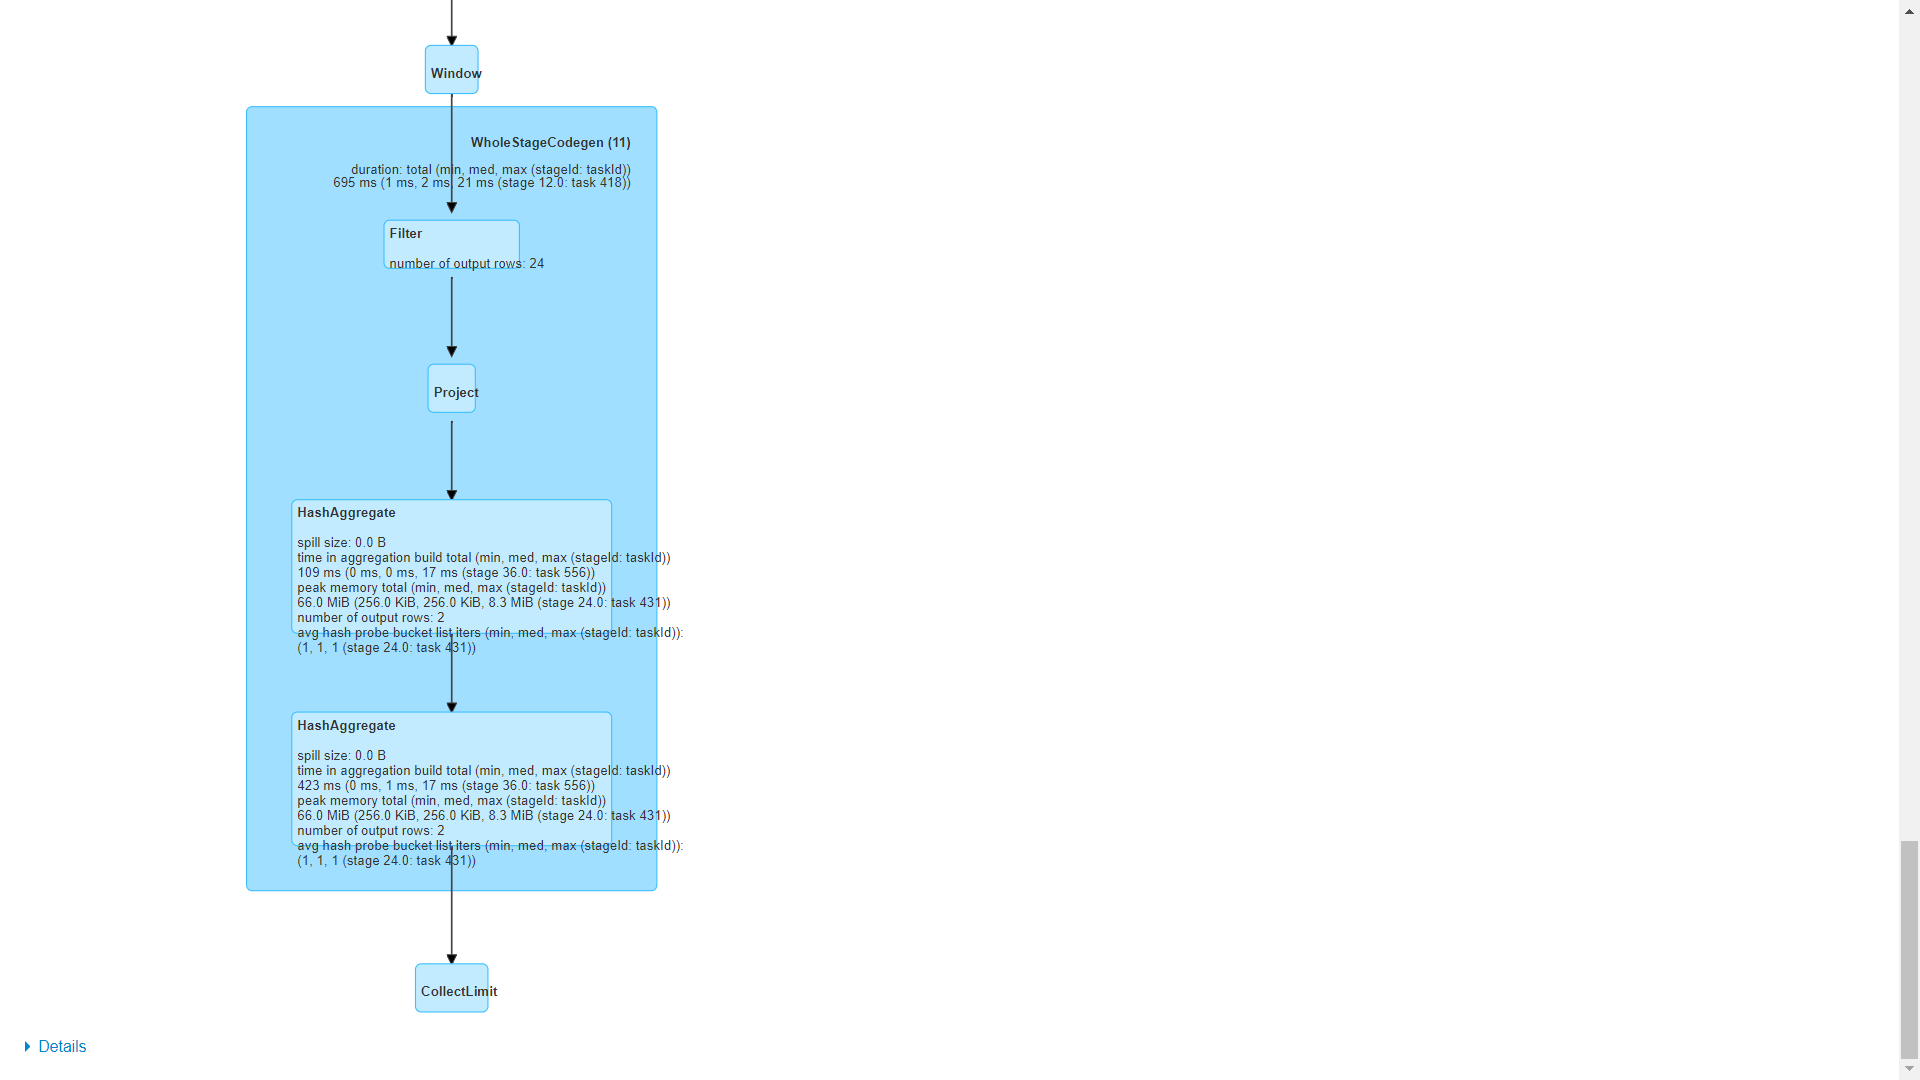

### Plan explanations:
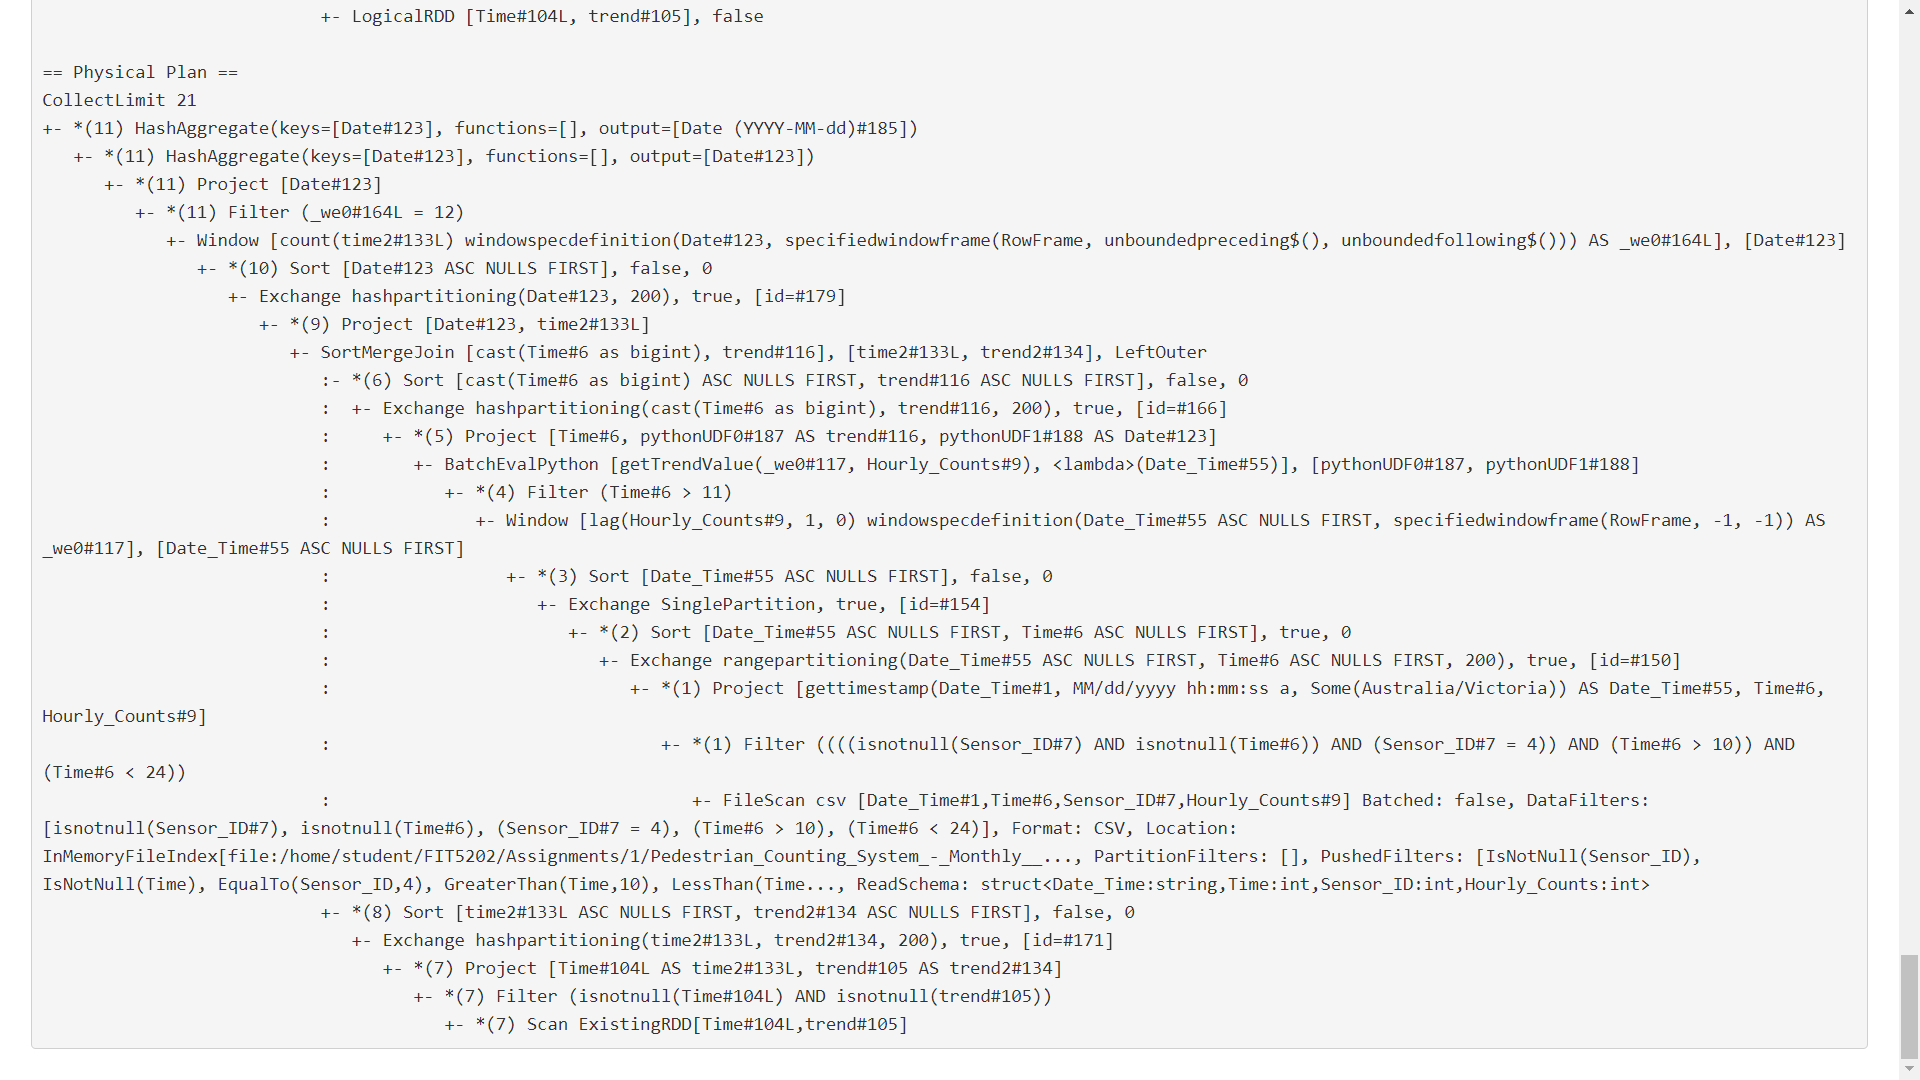
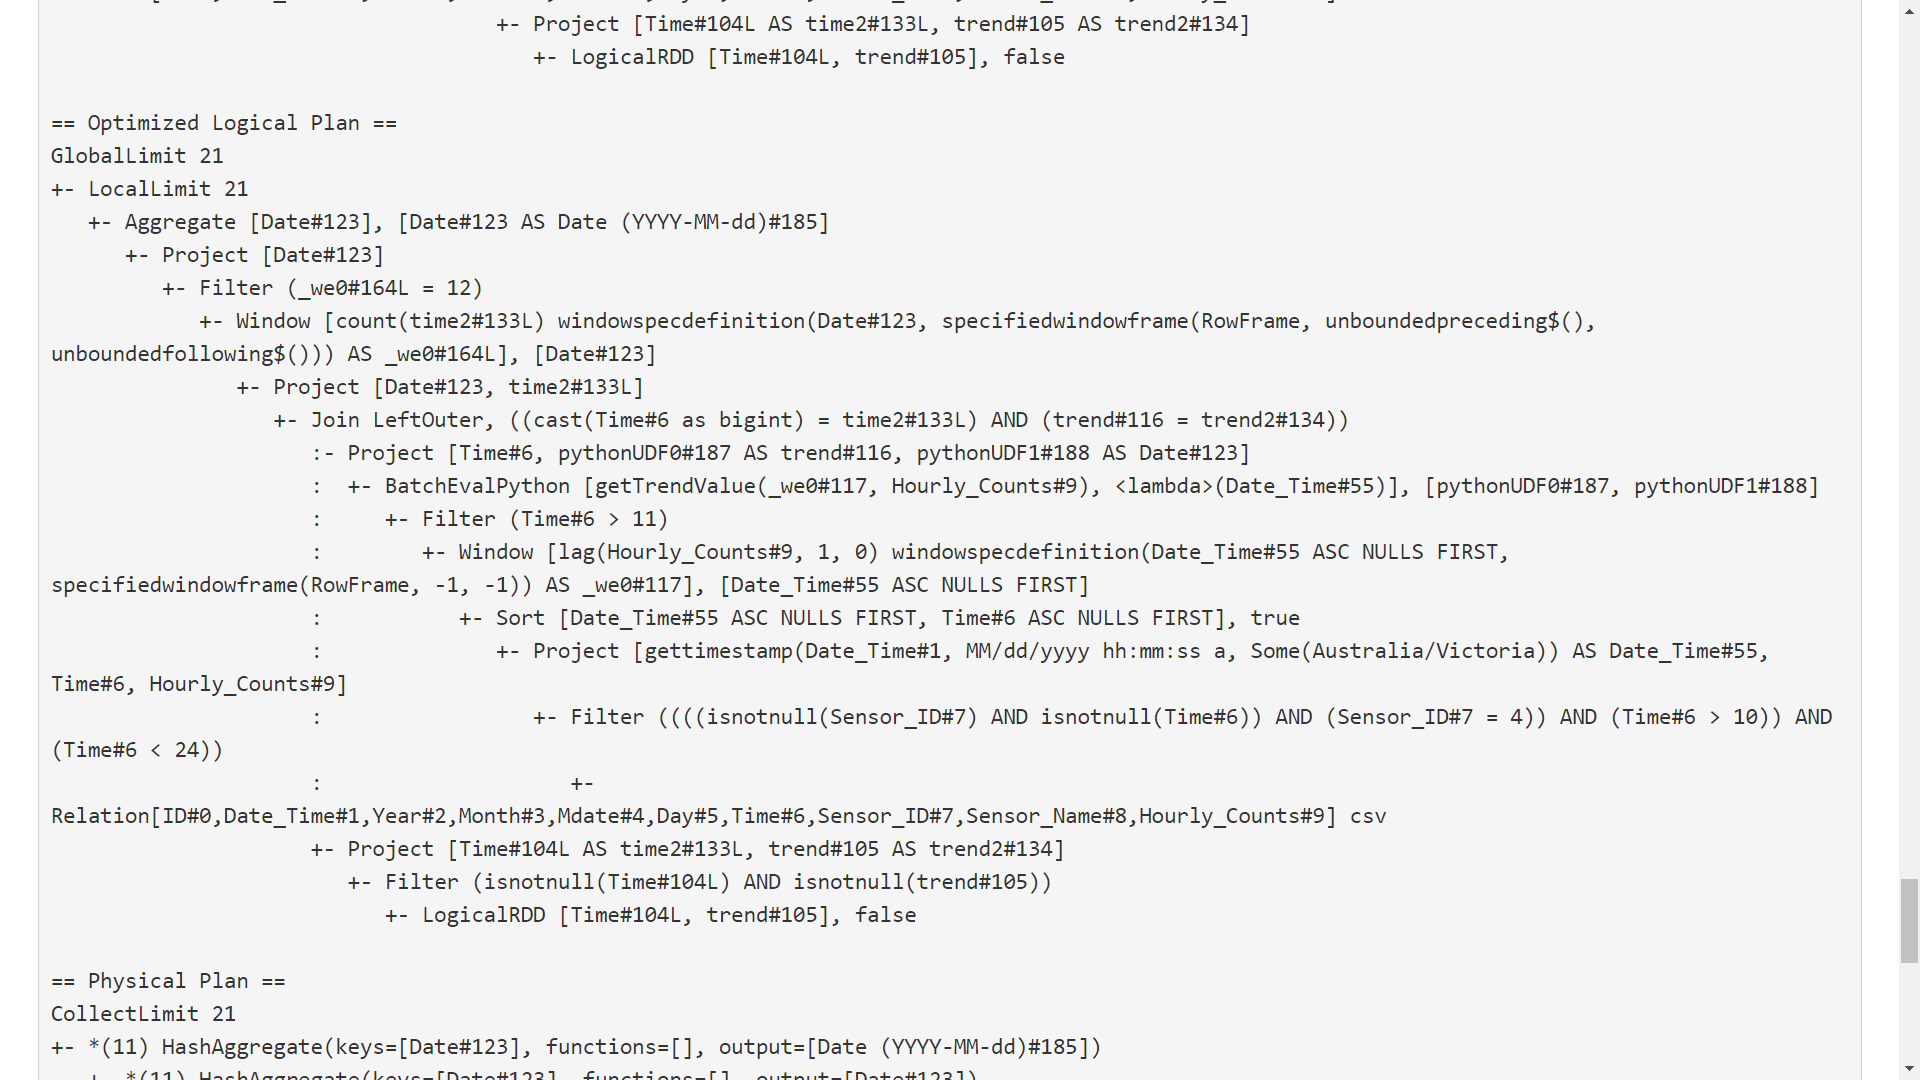
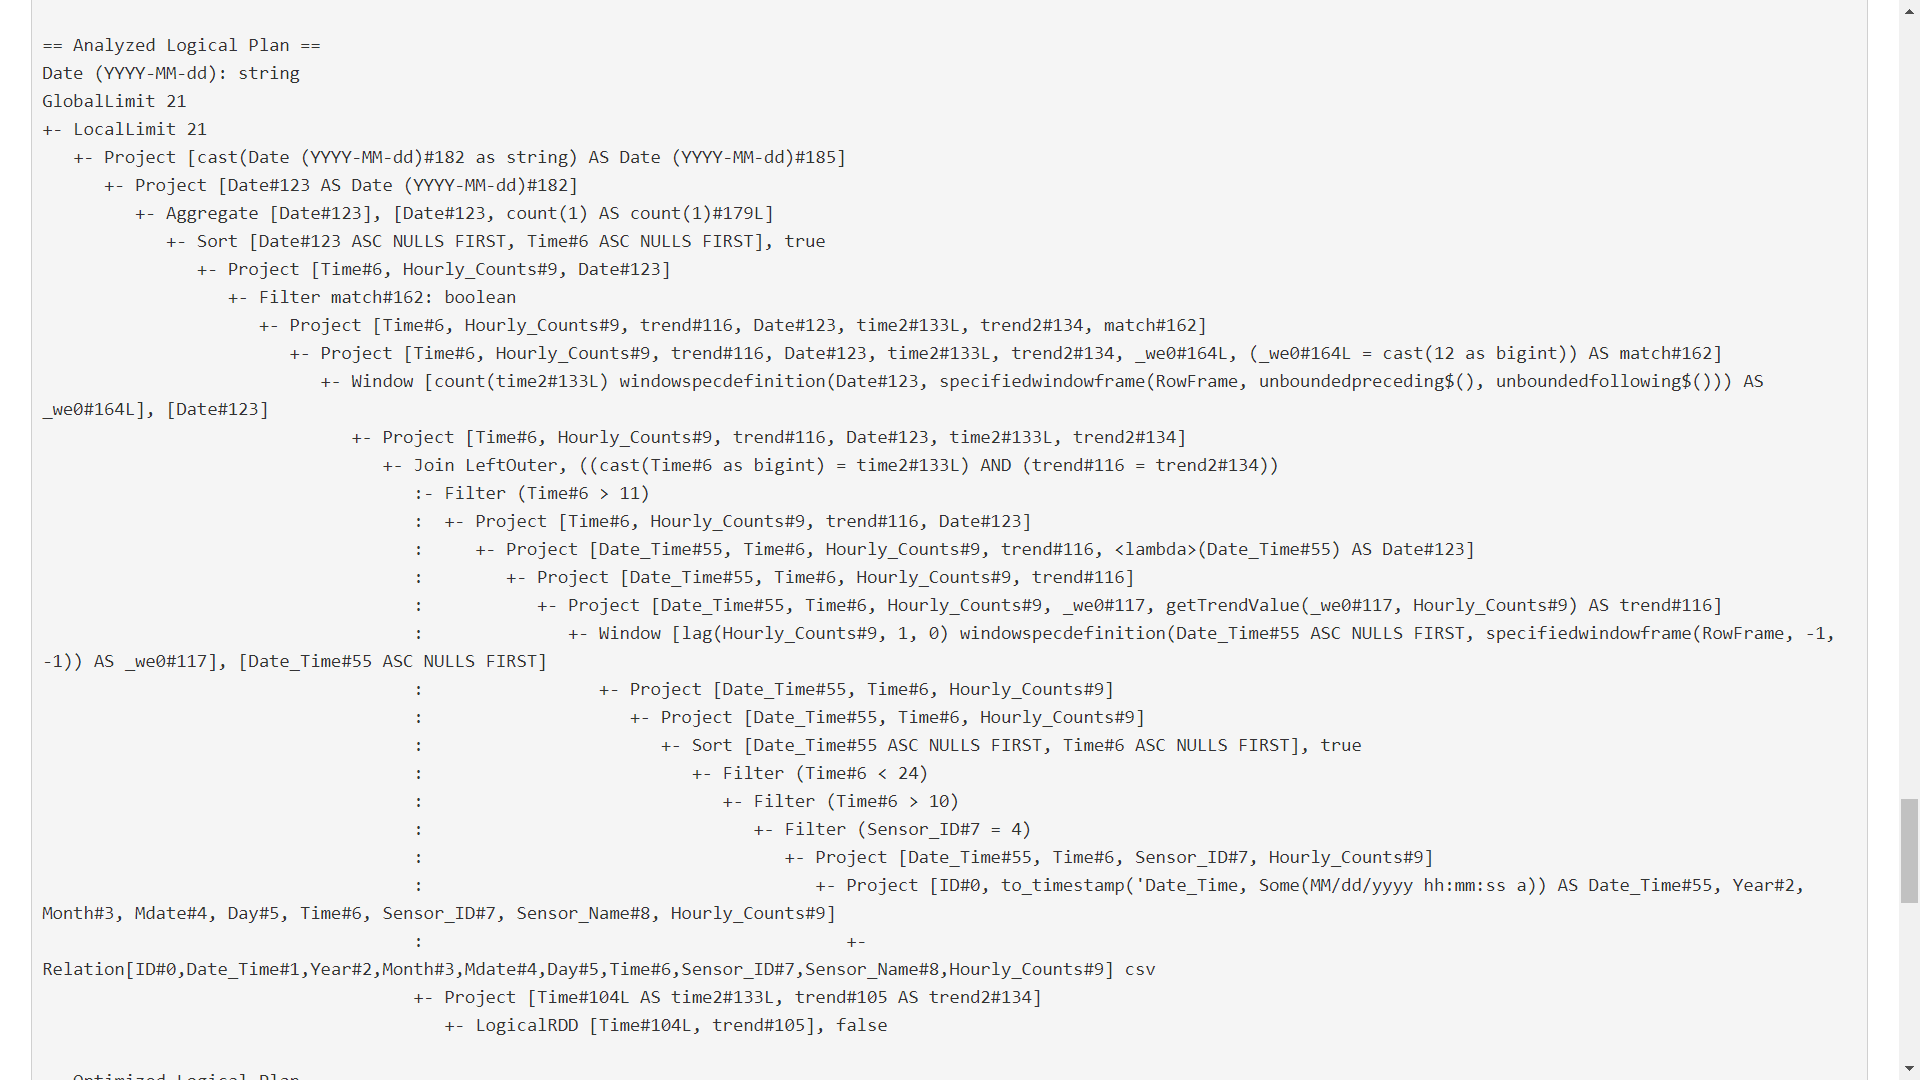
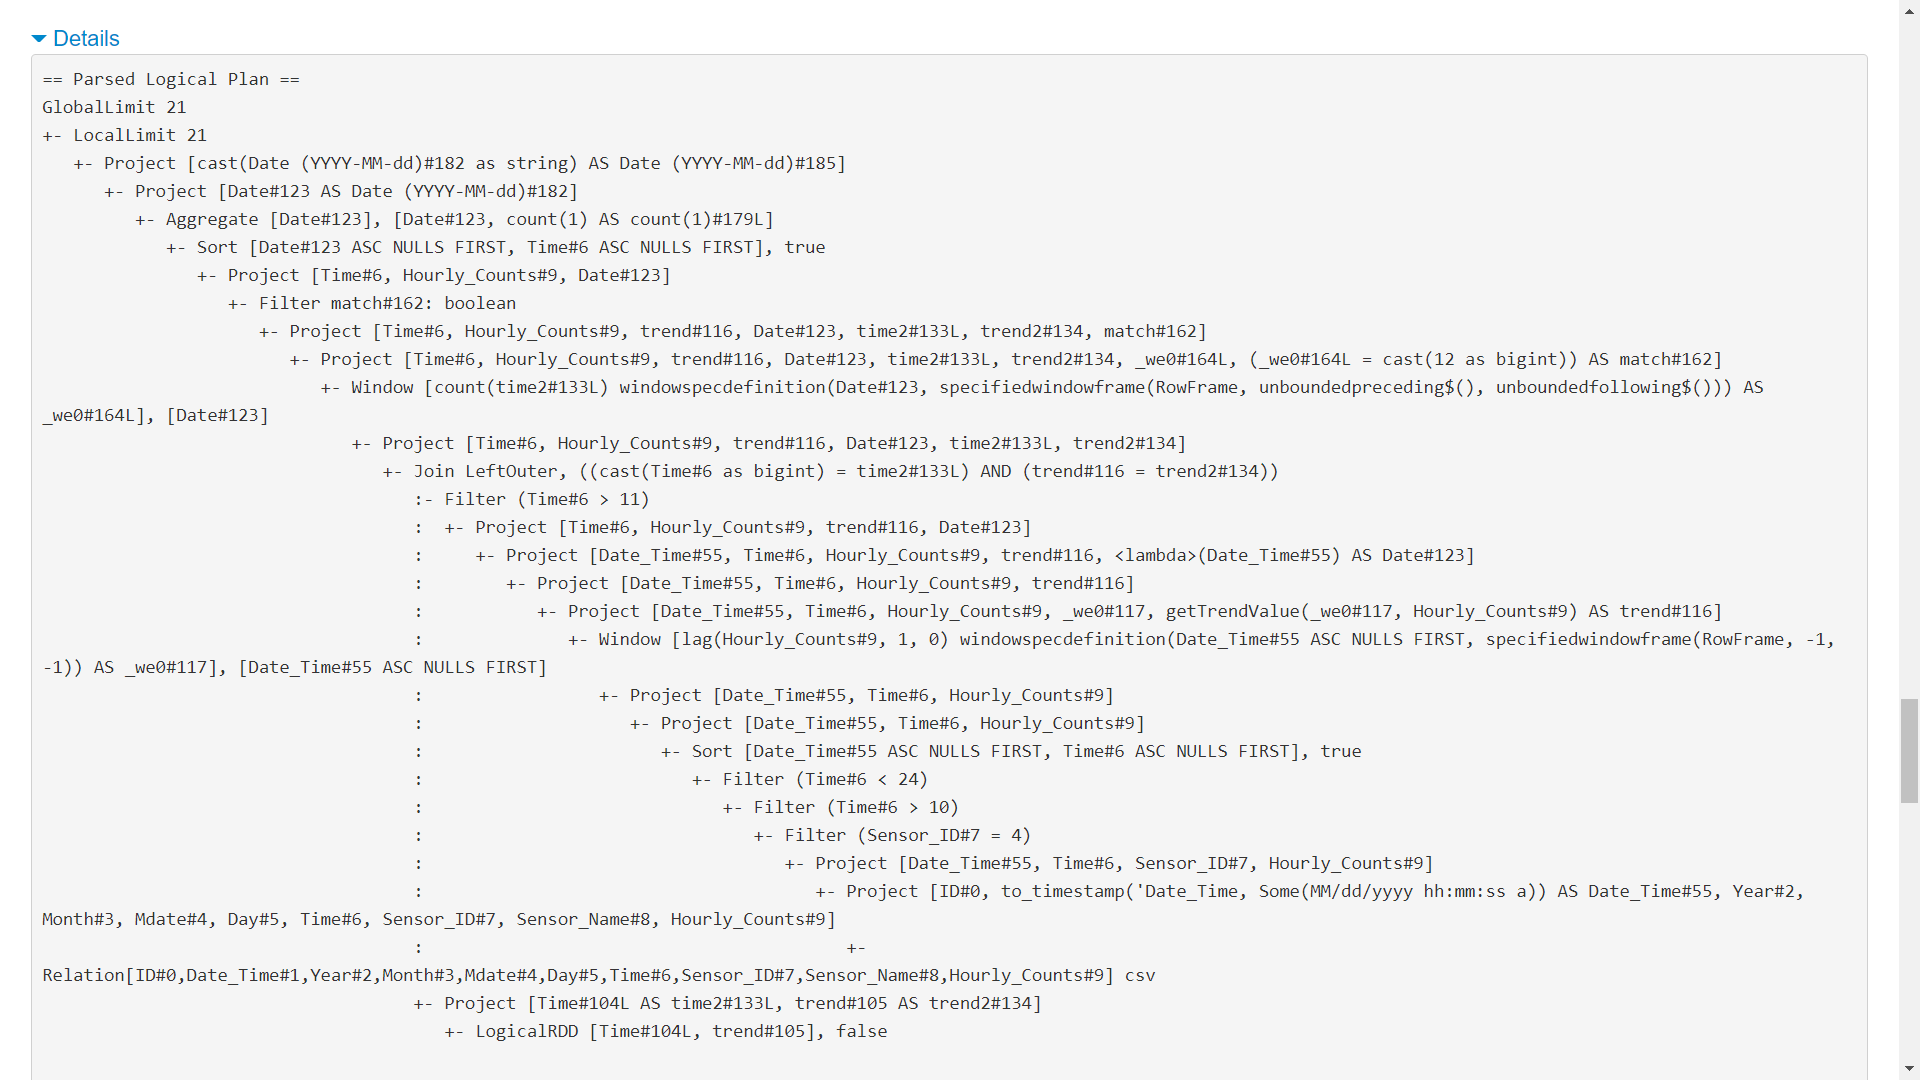

<a class="anchor" name="threetwotwo"></a>
### 3.2.2 SQL Query explanation

<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px">
    <strong style="color:#006DAE">SQL Query Plan explanation</strong>
    <div>
        <ul>
            <li>
                In Physical Plan: 
                <ul>
                    <li>First it apply range repartition on Date_Time column of table monthly count. And exchange.</li>
                    <li>Then, Sort by Date_Time.</li>
                    <li>Then, Add new column using window query -> 'trend'</li>
                    <li>Then, Filter data using Time.</li>
                    <li>Then, Project result with reduced columns.</li>
                    <li>Then, Hash partitioning on Time column. And Sort by Time</li>
                    <li>Then, Load and create replica of input dataframe and apply hash partitioning on joining columns.</li>
                    <li>Then, Sort by time column in input dataframe.</li>
                    <li>Then, Apply parallel sort merge join algorithm.</li>
                    <li>Then, Project output with creating Date column.</li>
                    <li>Then, excahnge hash partitioning using new Date column.</li>
                    <li>Then, Sort by Date.</li>
                    <li>Then, filter with match=true records.</li>
                    <li>Then, Project output in every partition.</li>
                    <li>Then, Hash Aggregate the outeput to driver.</li>
                </ul>
            </li>
            <li>
                In Logical Plan (Analyzed is the same Parsed Plan by query):
                <ul>
                    <li>Mostly, same as physical</li>
                </ul>
            </li>
            <li>
                In Optimized Logical Plan:
                <ul>
                    <li>Projections of columns are reduced.</li>
                </ul>
            </li>
        </ul>
    </div>
    <br>
    <div>
        <strong style="color:#006DAE">SQL Query Plan Improvments</strong>
        <ul>
            <li>Removing unnecessory steps like:</li>
            <li>&nbsp;&nbsp;&nbsp;&nbsp;Befor joining: Sorting columns, projecting columns</li>
            <li>Drop not required column: Sensor ID after filter.</li>
            <li>Count number of rows of input dataframe and store it to variable, then use variable to comparision in query.</li>
            <li>&nbsp;&nbsp;&nbsp;&nbsp;Insted of using dataframe to count rows in each comparision.</li>
        </ul>
    </div>
    <br>
    <div>
        <strong style="color:#006DAE">Performance:</strong>
        <code>After applying above step would execute query in 13 sec instead of 19 sec <strong>[31.5% increase]</strong> (Kernel was restared every time of new execution of query)</code>
    </div>
    <br>
    <div>
        <strong style="color:#006DAE">Note:</strong>
        <code>Last but not least, increasing the number of core count and size of main-memory, would result in much better performance in task like this or much heavy tasks.</code>
    </div>
    <p style='font-weight:bold; font-size:larger'>See below code for optimized query:</p>
</div>

In [14]:
# importing Window lib from pyspark.sql to use lag functionality on column
from pyspark.sql import Window
# importing sql types
from pyspark.sql.types import StringType
# importing sql functions
from pyspark.sql.functions import *

# Input data:
df_input = spark.createDataFrame({
    (12, 'increase', ),
    (13, 'increase', ),
    (14, 'increase', ),
    (15, 'decrease', ),
    (16, 'decrease', ),
    (17, 'decrease', ),
    (18, 'decrease', ),
    (19, 'increase', ),
    (20, 'increase', ),
    (21, 'increase', ),
    (22, 'decrease', ),
    (23, 'decrease', )
}, ['Time', 'trend'])

# To get trend column value
def getTrendValue(cellVal1, cellVal2):
    return 'increase' if cellVal1 < cellVal2 else 'decrease'

# udf functions
get_trend_val = udf(getTrendValue, StringType())
convert_date = udf(lambda cellVal: cellVal.strftime('%Y-%m-%d'), StringType())

## Optimized query:
# Removed unnecessory actions
#     .orderBy(df_monthly_pad_count.Date_Time, df_monthly_pad_count.Time)\
#     .select(df_monthly_pad_count.Date_Time, df_monthly_pad_count.Time, df_monthly_pad_count.Hourly_Counts)\
# Declare global count
input_row_count = df_input.count()
df_abstract = df_monthly_pad_count\
    .drop('ID', 'Year', 'Month', 'Mdate', 'Day', 'Sensor_Name')\
    .filter(df_monthly_pad_count.Sensor_ID == 4)\
    .filter(df_monthly_pad_count.Time > 10)\
    .filter(df_monthly_pad_count.Time < 24)\
    .drop(df_monthly_pad_count.Sensor_ID)\
    .withColumn('trend', \
                get_trend_val(lag(df_monthly_pad_count.Hourly_Counts, default=0)\
                               .over(Window.orderBy(df_monthly_pad_count.Date_Time)), \
                               df_monthly_pad_count.Hourly_Counts))\
    .withColumn('Date', convert_date(df_monthly_pad_count.Date_Time))\
    .drop('Date_Time')\
    .filter(df_monthly_pad_count.Time > 11)\
    .join(df_input.toDF('time2', 'trend2'), expr('Time = time2 and trend = trend2'), 'left')\
    .withColumn('match', expr(f"count(time2) over(partition by Date) = {input_row_count}"))\
    .filter('match')\
    .drop('match', 'time2', 'trend2', 'trend')\
    .sort('Date', 'Time')

print("Dates for sensor 4 that follows the input trend patterns:")
df_abstract.groupBy('Date').agg(count('*')).select(col('Date').alias('Date (YYYY-MM-dd)')).show(truncate = False)

Dates for sensor 4 that follows the input trend patterns:
+-----------------+
|Date (YYYY-MM-dd)|
+-----------------+
|2009-12-31       |
|2019-12-24       |
+-----------------+



<div style='font-weight:bold; font-size:large; text-align:center; color:blue;'>
* End of assignment 1 *
<div>